In [192]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import glob
import pytesseract
from PIL import Image, ImageFilter
from IPython.display import display
import os
import collections
from threading import Thread
from tqdm import tqdm
from skimage import io
from skimage.transform import rescale
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage.filters import sobel
from skimage import util 
from skimage import segmentation
import skimage
from skimage.util import img_as_ubyte
from skimage.filters import threshold_local
import ntpath
%pylab inline
%matplotlib inline
from skimage import img_as_uint
import copy
pylab.rcParams['figure.figsize'] = (15, 8)

Populating the interactive namespace from numpy and matplotlib


In [321]:
import numpy as np
from PIL import Image
import glob
import pytesseract
from IPython.display import display
import os
import collections
import ntpath
import copy
import cv2

import skimage
from skimage import io, util, segmentation, img_as_uint
from skimage.transform import rescale
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage.filters import sobel, threshold_local
from skimage.util import img_as_ubyte

def sort_boxes(contours):
    """Sort the contours from left to right and return the bounded boxes of the contours."""
    boundingBoxes = [cv2.boundingRect(c) for c in contours]
    # Sort boxes by x-coordinate + width
    (contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes), key=lambda b:(b[1][0]+b[1][2])))
    return boundingBoxes

def crop(img):
    """Crop the right part of the image not containing text (keep only centered big boxes)"""
    img_final = copy.deepcopy(img)
    img2gray = copy.deepcopy(img)
    # Binarise image, inverting black and white (cv2 finds contours of white on top of black)
    ret, mask = cv2.threshold(img2gray, 180, 255, cv2.THRESH_BINARY)
    image_final = cv2.bitwise_and(img2gray , img2gray , mask =  mask)
    ret, new_img = cv2.threshold(image_final, 180 , 255, cv2.THRESH_BINARY_INV)
    # Find contours
    contours = cv2.findContours(new_img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)[1]

    # Keep right most coordinate of the boxes kept
    maxWidth = 0
    height= img_final.shape[0]
    precX = 0
    for box in sort_boxes(contours):
        # get rectangle bounding contour
        [x, y, w, h] = box
        # We skip the box if 1) it's too small 2) It's on the top 3) It's on the bottom 4) The space between the box and box kept on the left is too big
        if (h < 10 and w < 10) or (y < 10 and (y+h < 0.2*height)) or (y+20 > height) or (x - precX > 50):
            continue
        # the x coordinate of the object is on the right
        if maxWidth < (x + w):
            maxWidth = x + w
        # It's the right most box
        if x + w > precX:
            precX = x+w
    cropped = img_final[0 : height , 0 : maxWidth+10]
    return cropped

def denoiseBoxFromPath(path, savePath, clearBorder = True, minSizeDark = 10, minSizeMid = 5, minSizeLight = 1, binThresh = 11):
    """Read skimage from path, apply denoise function and save it to folder savePath."""
    img = io.imread(path, as_grey=True)
    cleaned = denoiseBoxFromImage(img, savePath, clearBorder, minSizeDark, minSizeMid, minSizeLight, binThresh)
    if clearBorder:
        borderCleaned = "clearedBorder"
    else:
        borderCleaned =  "borderNotCleared"
    plt.subplot(1,2,1),plt.imshow(img, cmap='gray')
    plt.subplot(1,2,2), plt.imshow(cleaned, cmap='gray')
    plt.show()
    cleaned.save(savePath+"/cleaned_"+borderCleaned+ntpath.basename(path))

def denoiseBoxFromImage(img, savePath, clearBorder = True, minSizeDark = 15, minSizeMid = 10, minSizeLight = 5, binThresh = 1001, cropAfterDenoise = False):
    """Denoise an image (of format np.ndarray with values 0 to 255) and return the cleaned Pillow image."""
    img1 = copy.deepcopy(img)
    img = crop(img1)
    img_init = copy.deepcopy(img)
    xSize, ySize = img.shape
    ratio =  (xSize*ySize) / standardPixels
    # Initial binarised image (just the dark pixels)
    img_init_bool = img > 200

    # Binarise image with local threshold
    local_thresh = threshold_local(img, binThresh)
    img_thresh = img > local_thresh

    # Amount of black to determine the noise level
    white = img_thresh[(img_thresh == True)].size
    if white == 0:
        blackWhiteRatio = 1
    else:
        blackWhiteRatio = img_thresh[(img_thresh == False)].size / white
    # Black/white inverted
    reverse = util.invert(img_thresh)
    # Find connected components
    label_objects, nb_labels = ndi.label(reverse)
    # Remove border components if needed
    if (clearBorder):
        label_objects = segmentation.clear_border(label_objects)
    sizes = np.bincount(label_objects.ravel())
    #mask_sizes = sizes > (minSize * ratio * blackWhiteRatio)
    if blackWhiteRatio > 0.5:
        minSize = minSizeDark
    elif blackWhiteRatio > 0.3:
        minSize = minSizeMid
    else:
        minSize = minSizeLight
    mask_sizes = sizes > minSize
    mask_sizes[0] = 0
    cleaned = util.invert(mask_sizes[label_objects])  
    
    # Matrix containing true if the pixel has been removed
    pixelsRemoved = cleaned.__xor__(img_init_bool)
    img_init[pixelsRemoved] = 255

    if clearBorder:
        borderCleaned = "clearedBorder"
    else:
        borderCleaned =  "borderNotCleared"
    if cropAfterDenoise:
        img_init = crop(img_init)
    imgPil = Image.fromarray(np.array(img_init, dtype='uint8'))
    
    return imgPil

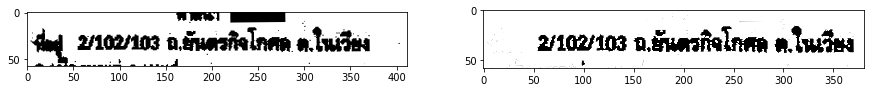

In [319]:
denoiseBoxFromPath("text_boxes/cropped_bigger/address/402_cropped_rot_address_l1.TIFF","text_boxes")

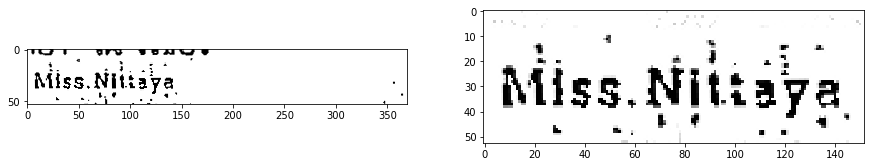

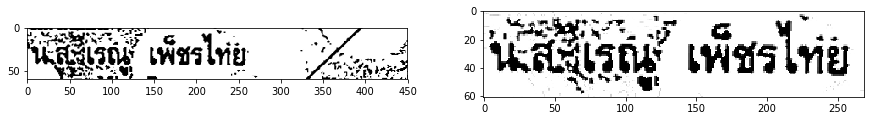

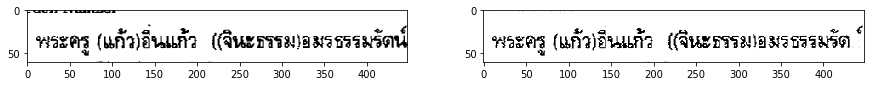

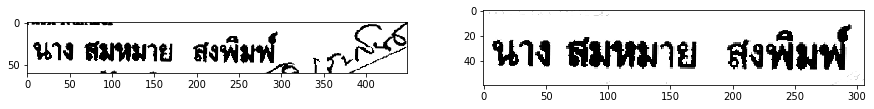

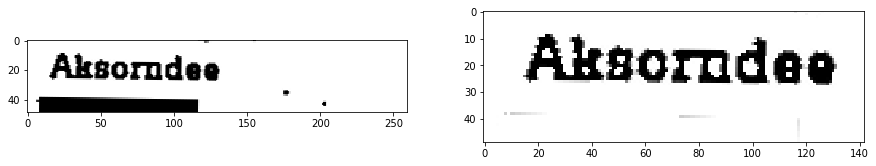

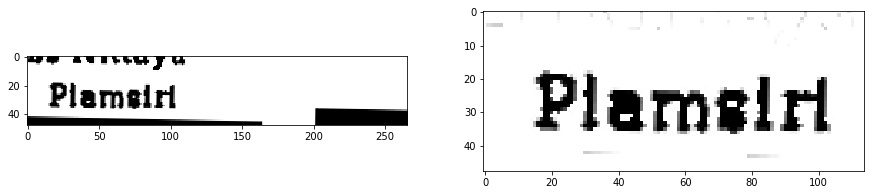

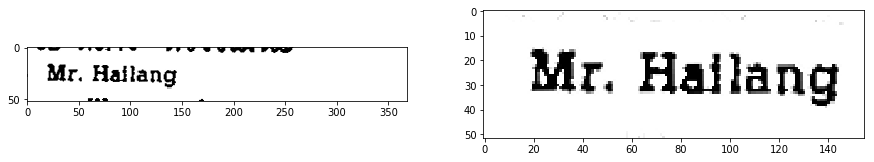

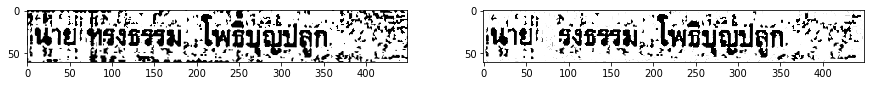

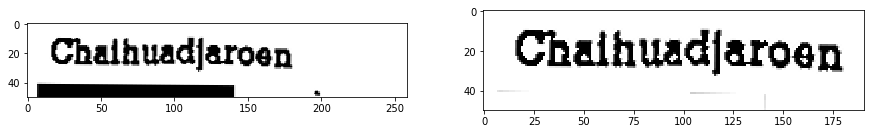

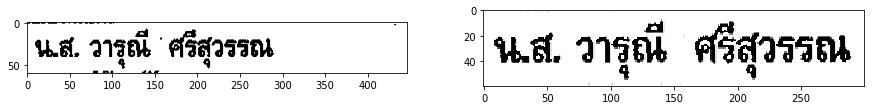

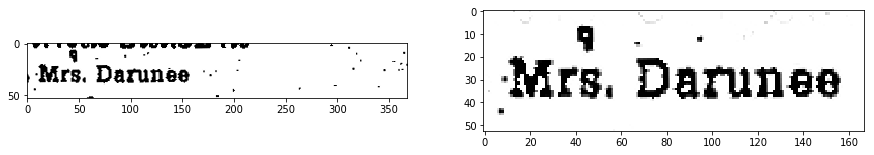

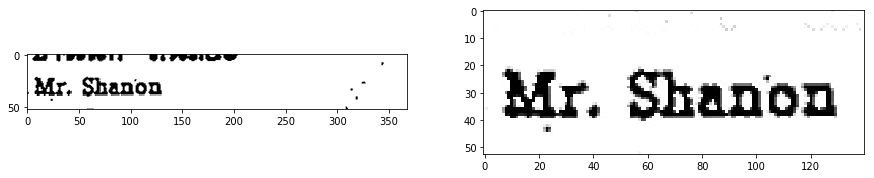

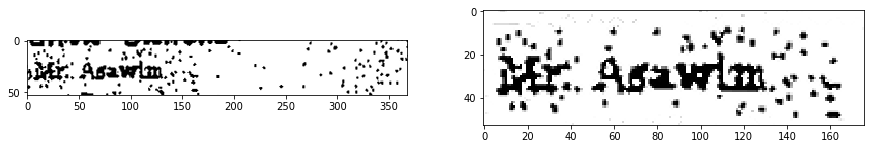

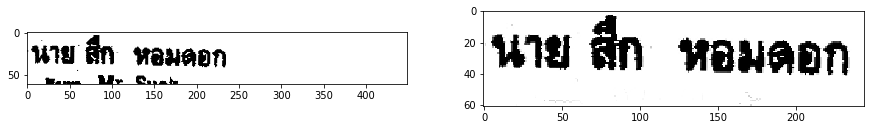

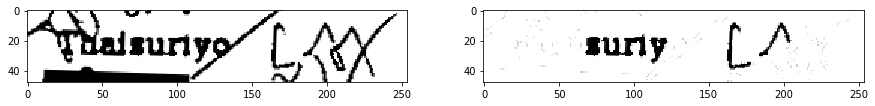

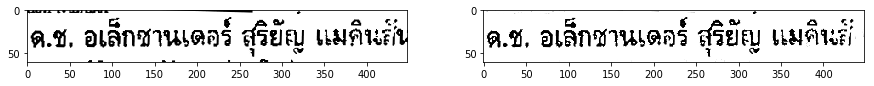

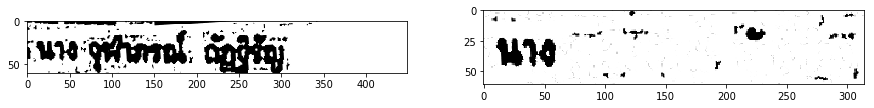

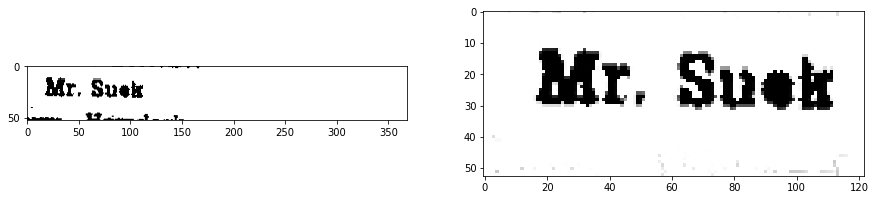

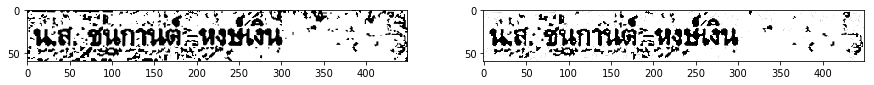

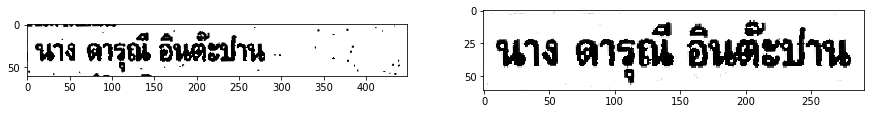

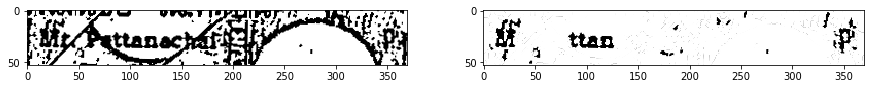

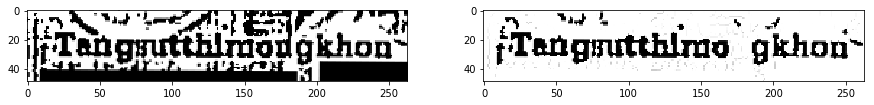

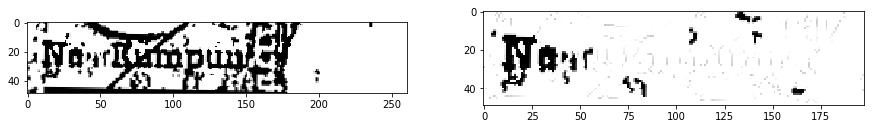

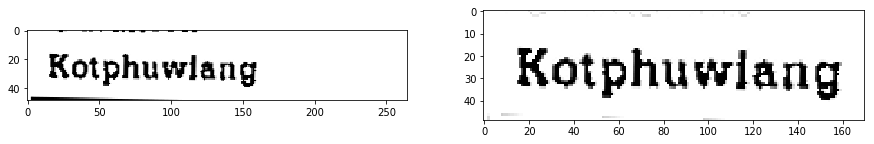

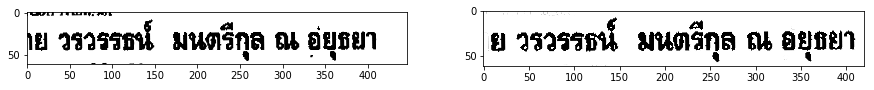

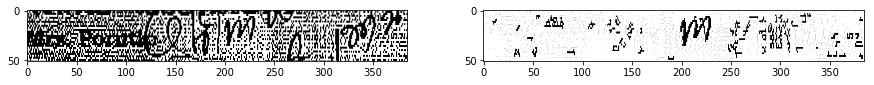

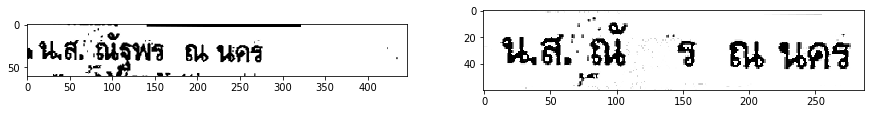

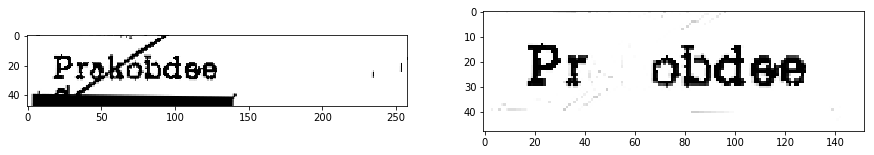

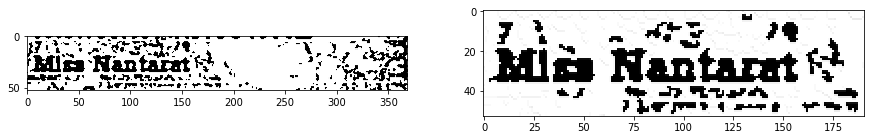

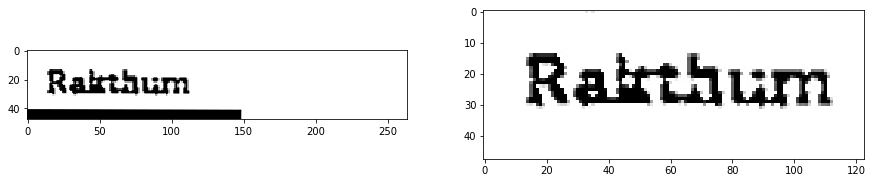

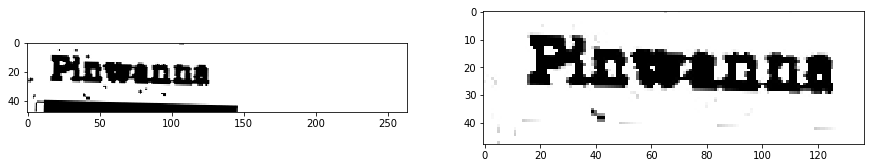

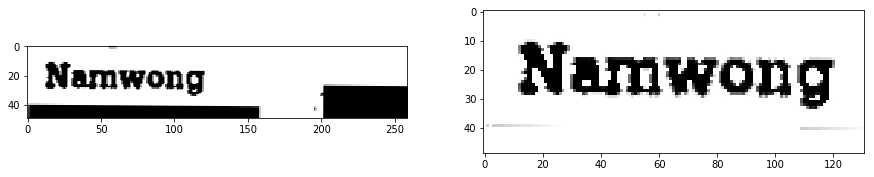

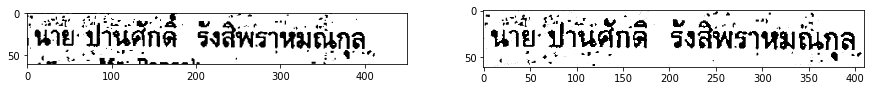

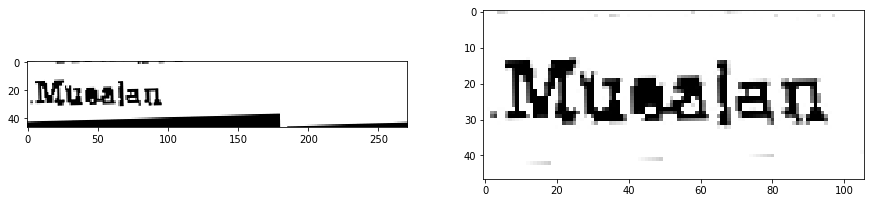

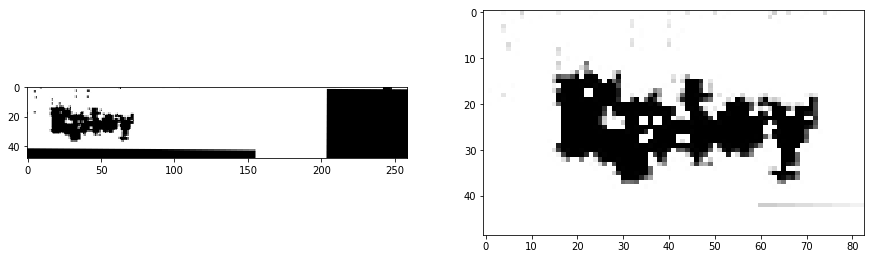

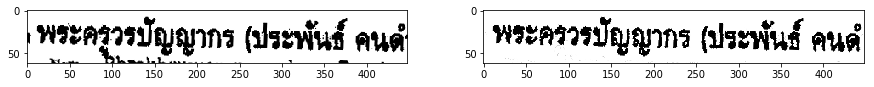

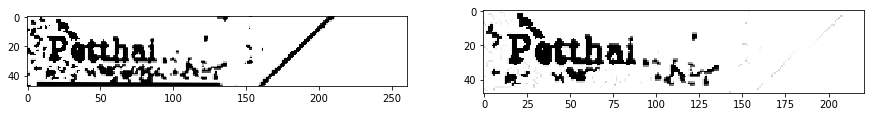

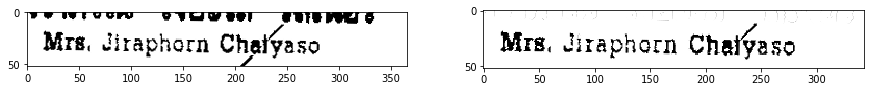

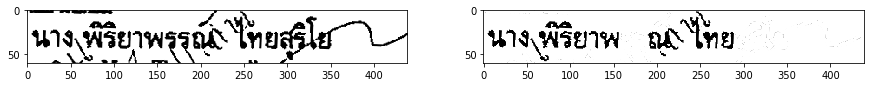

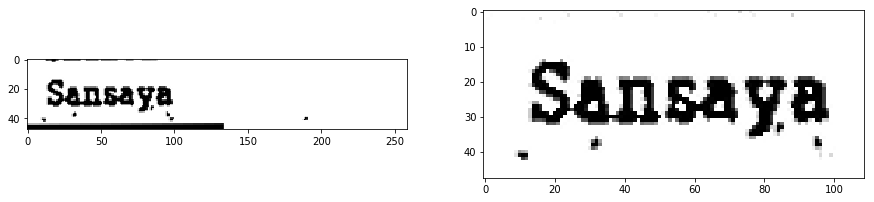

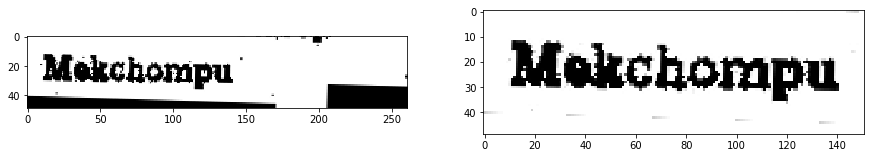

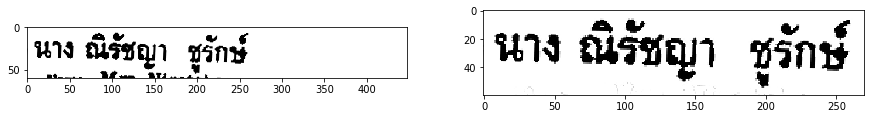

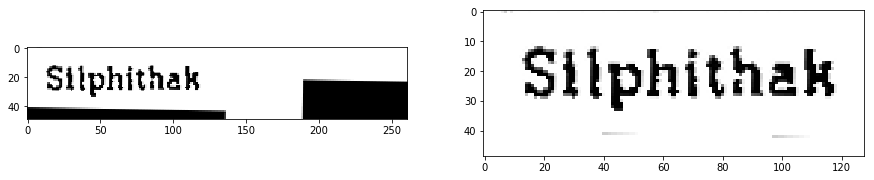

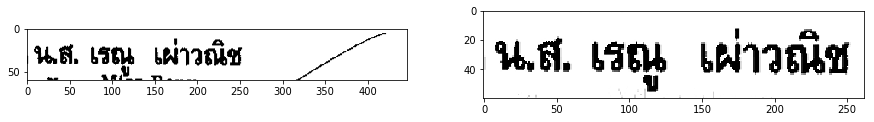

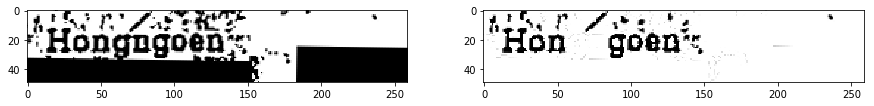

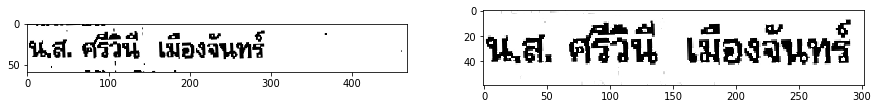

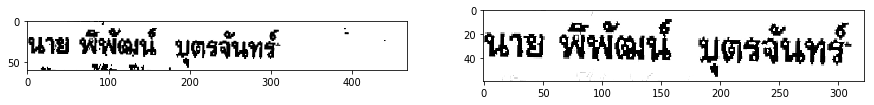

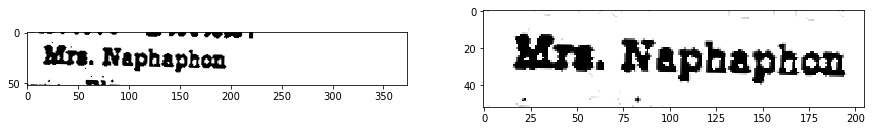

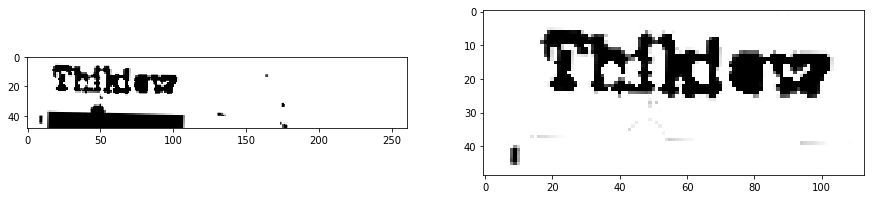

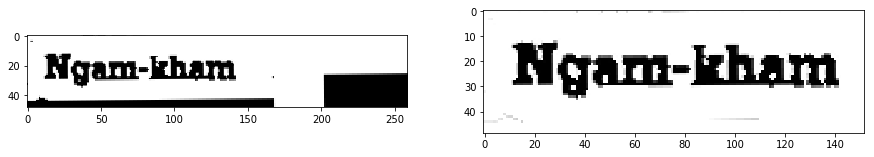

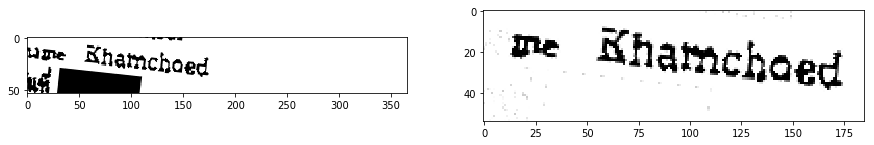

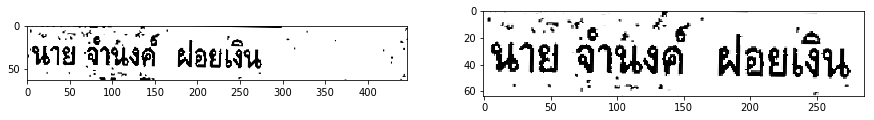

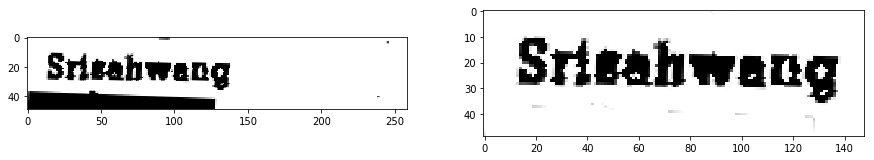

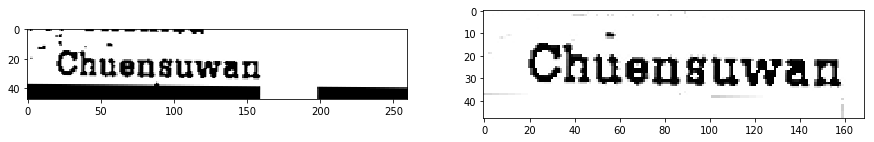

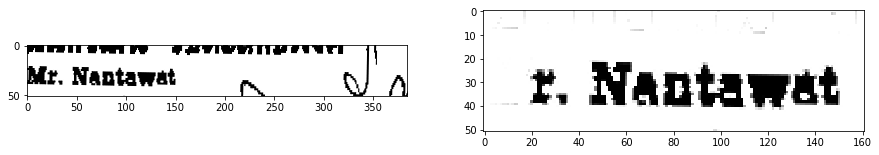

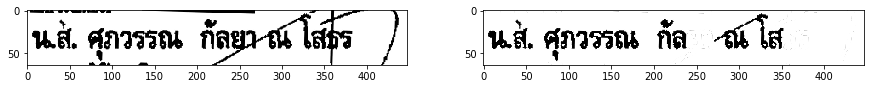

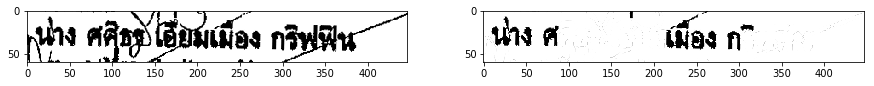

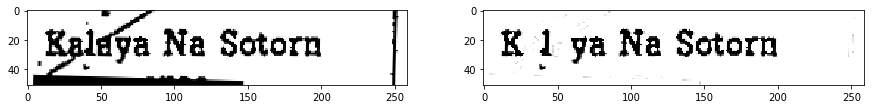

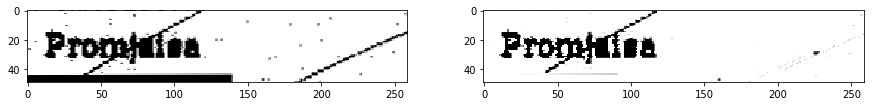

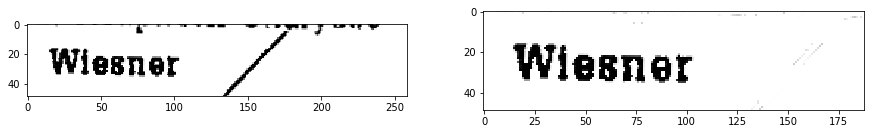

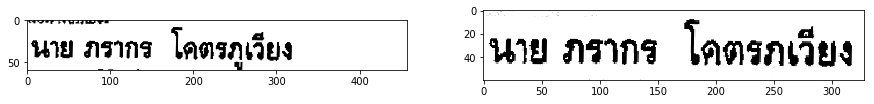

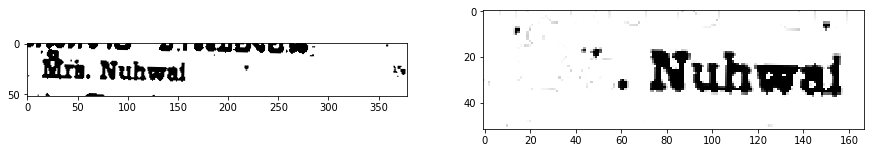

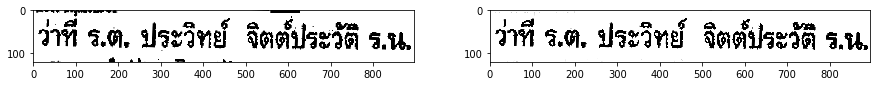

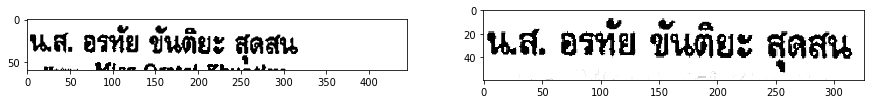

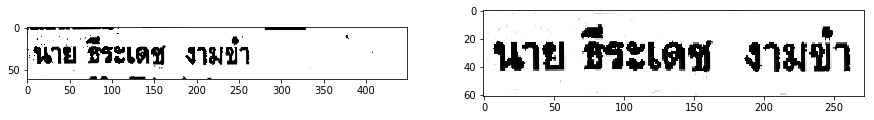

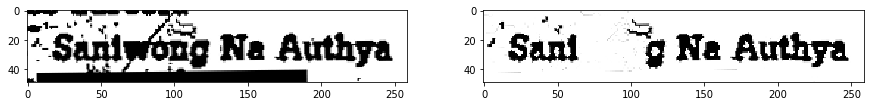

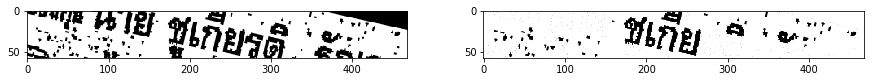

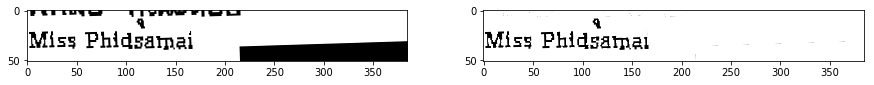

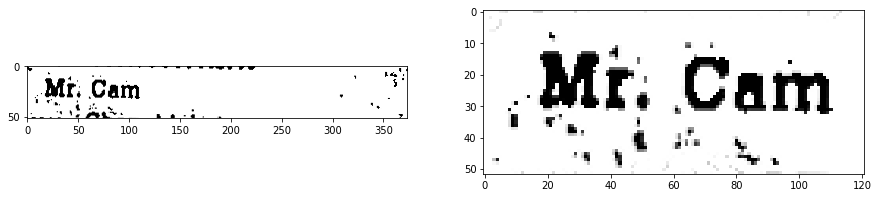

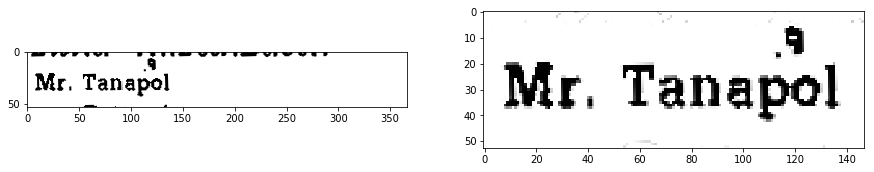

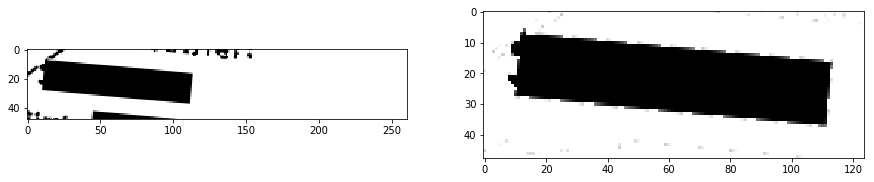

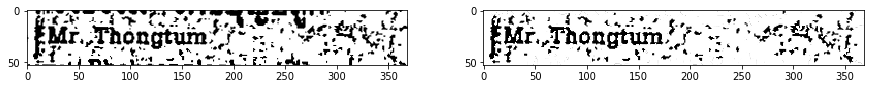

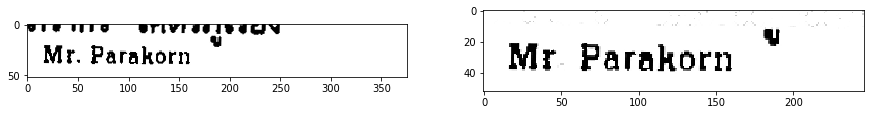

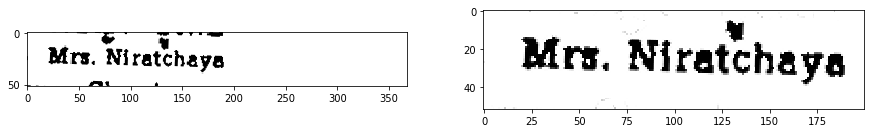

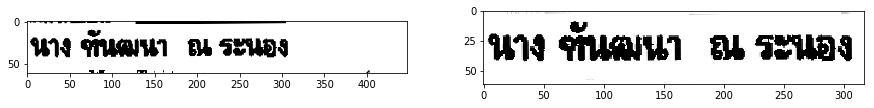

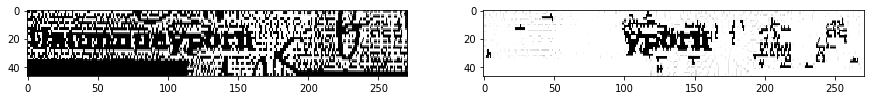

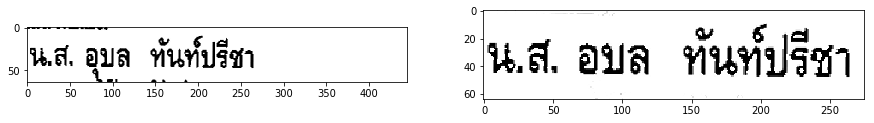

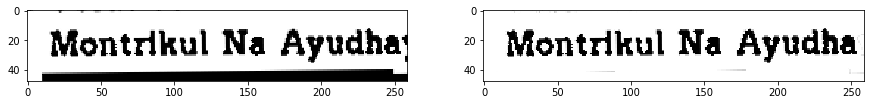

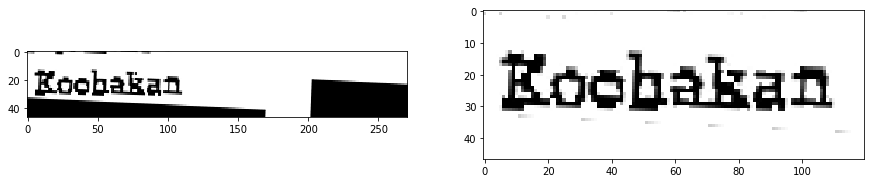

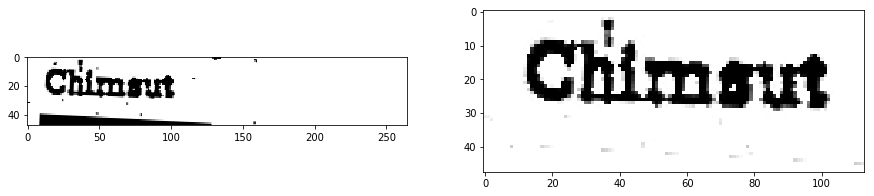

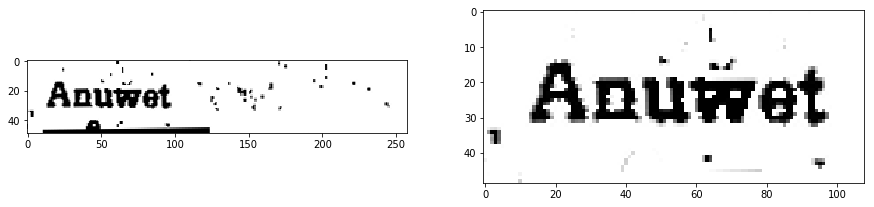

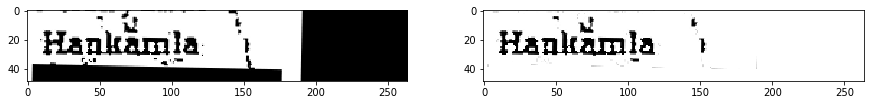

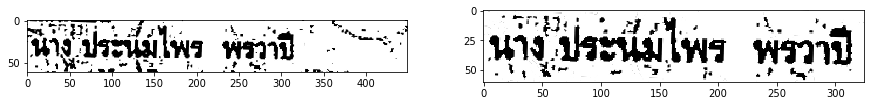

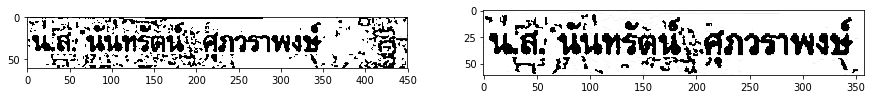

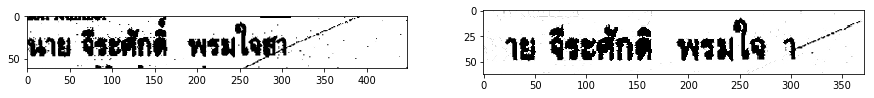

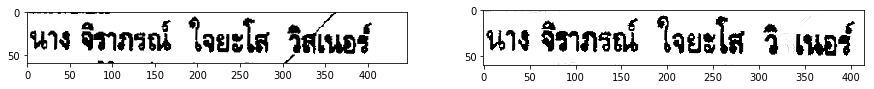

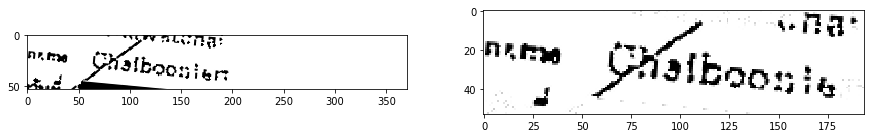

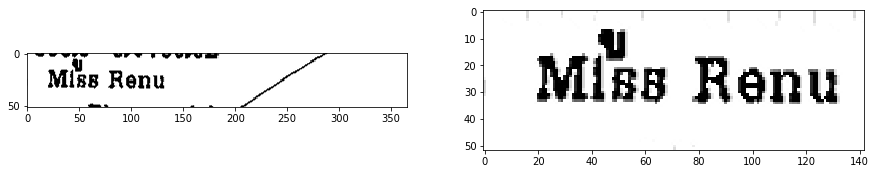

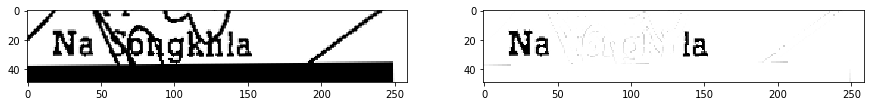

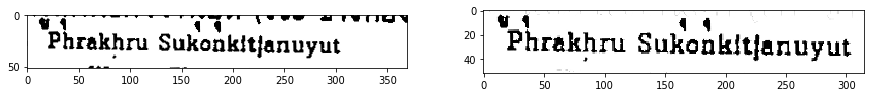

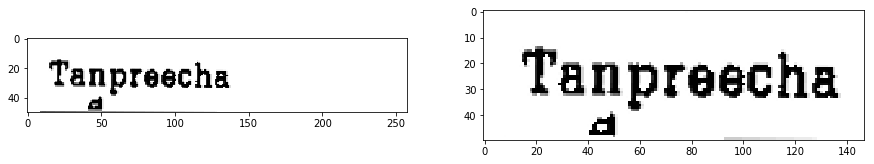

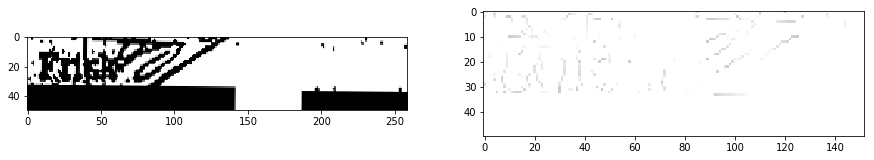

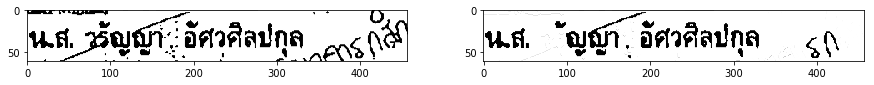

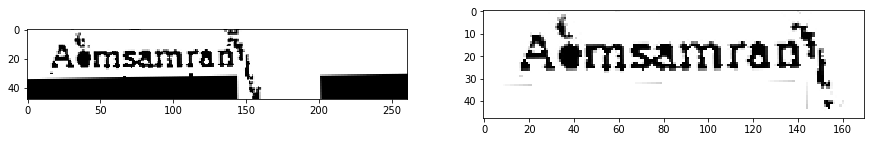

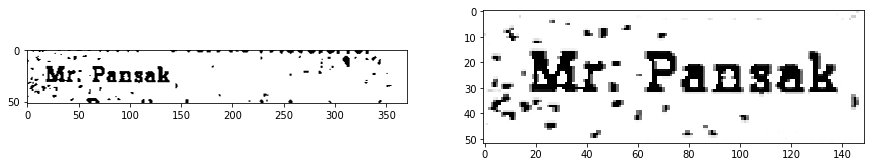

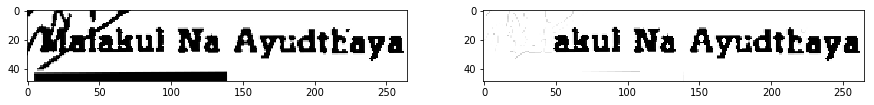

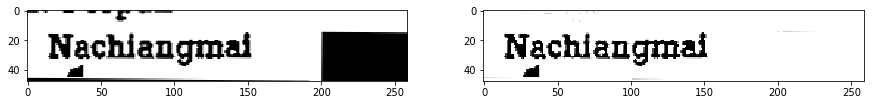

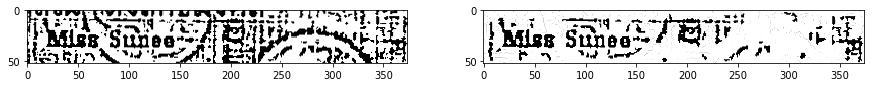

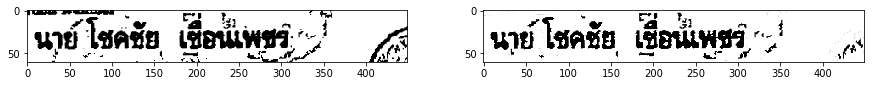

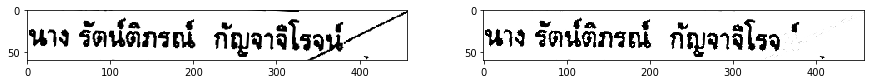

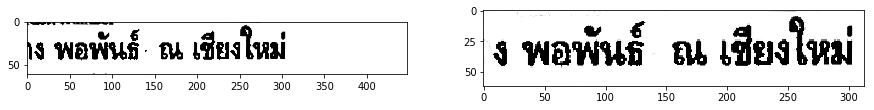

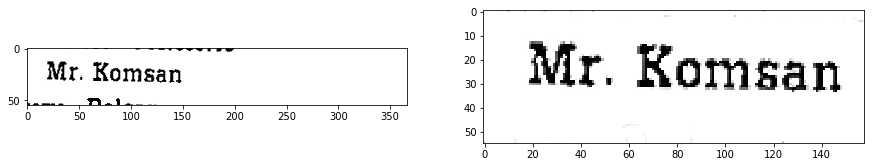

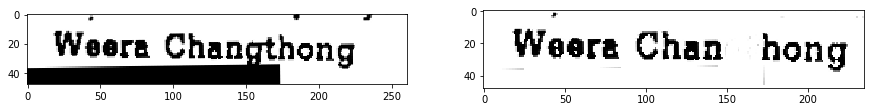

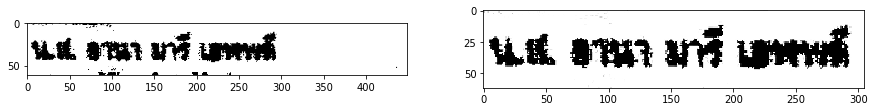

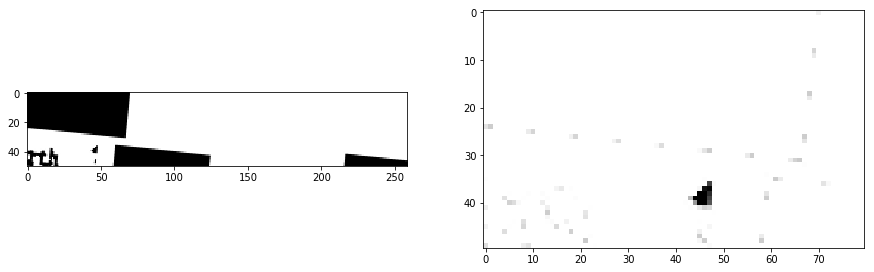

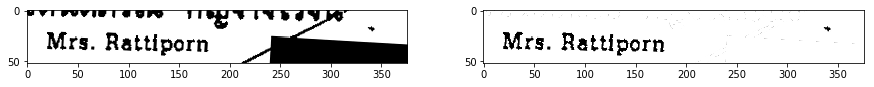

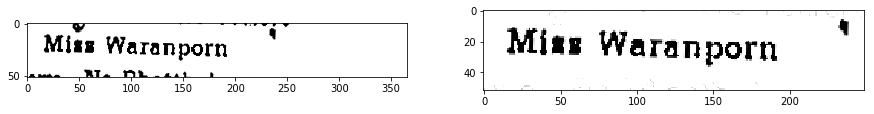

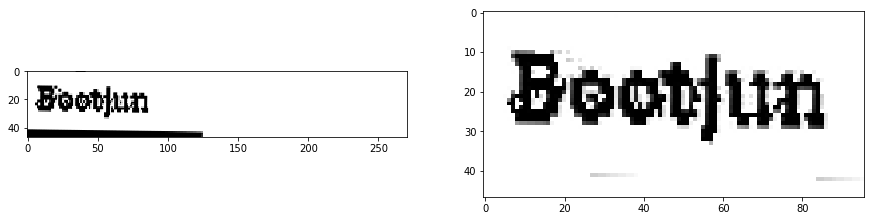

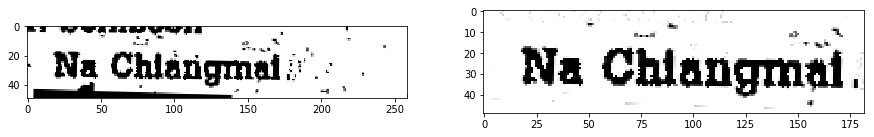

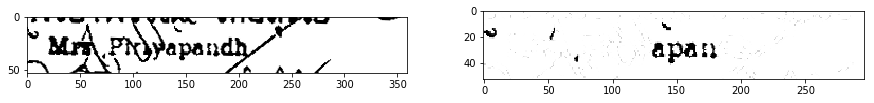

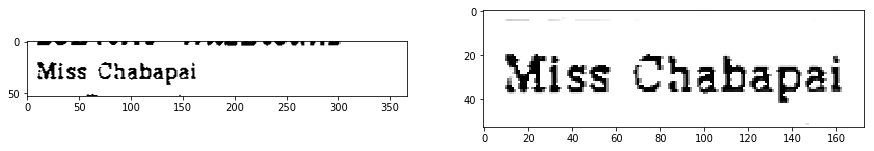

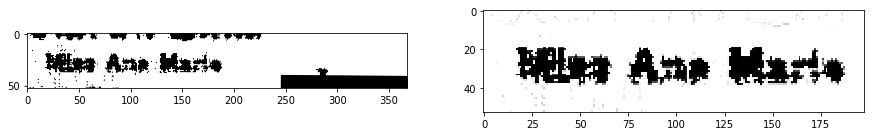

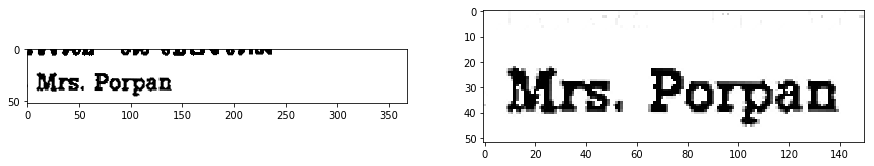

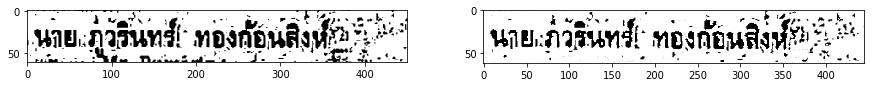

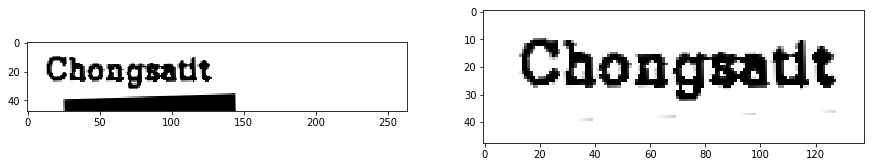

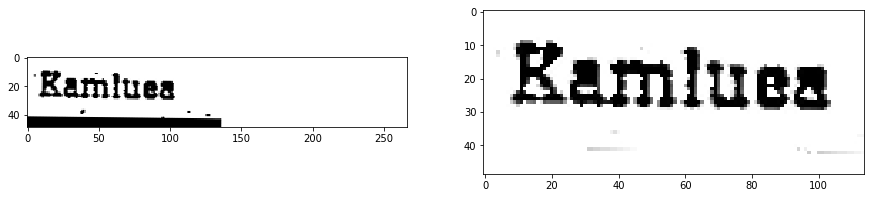

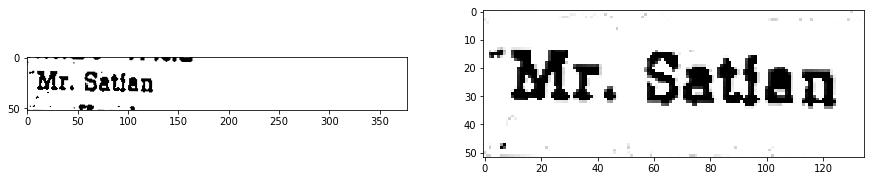

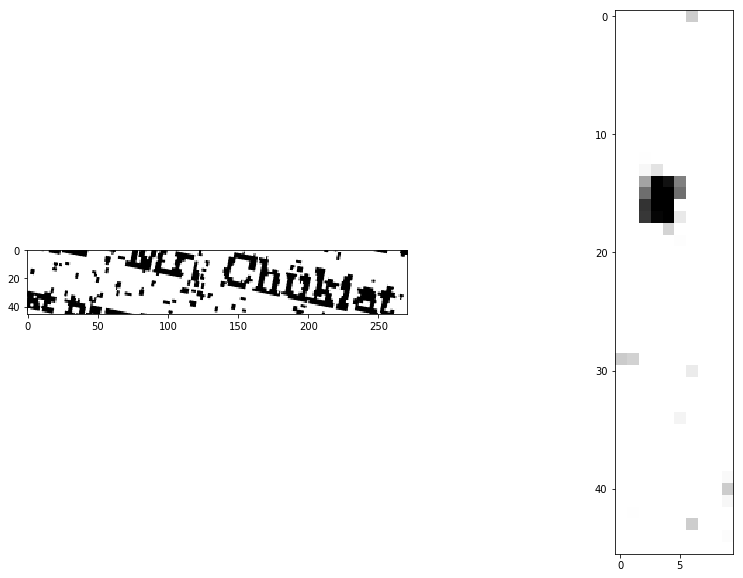

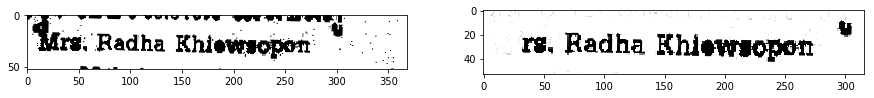

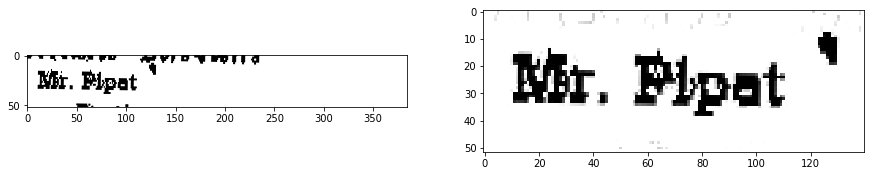

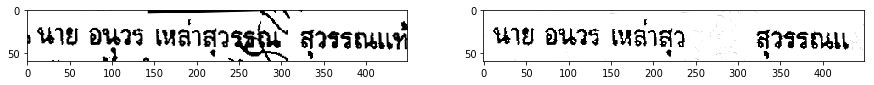

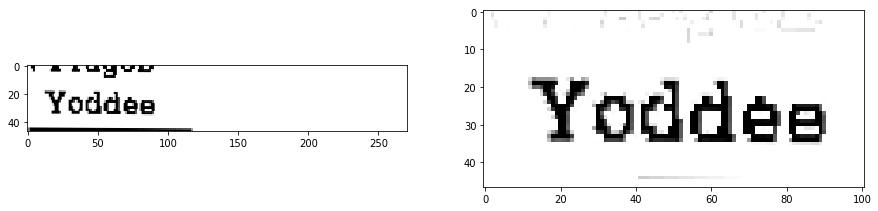

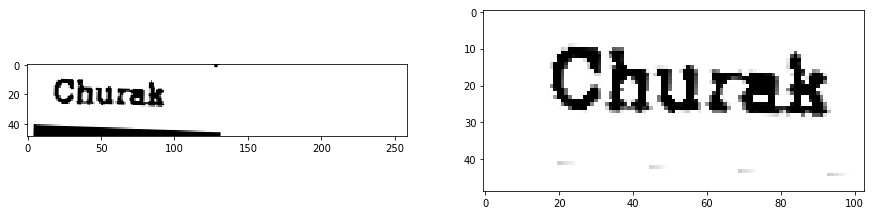

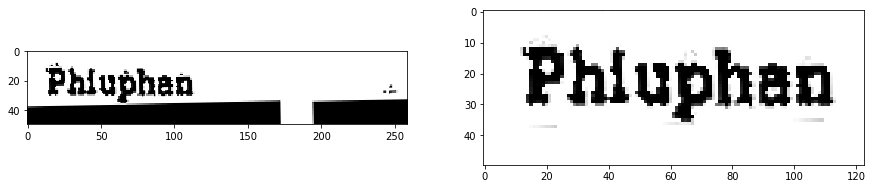

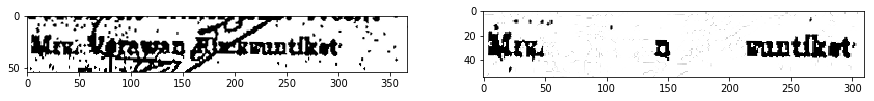

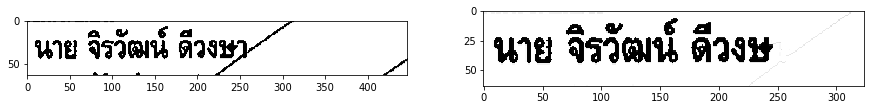

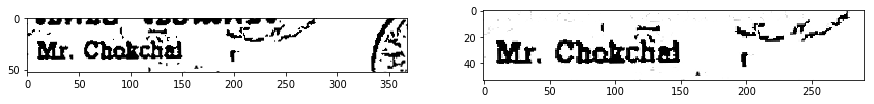

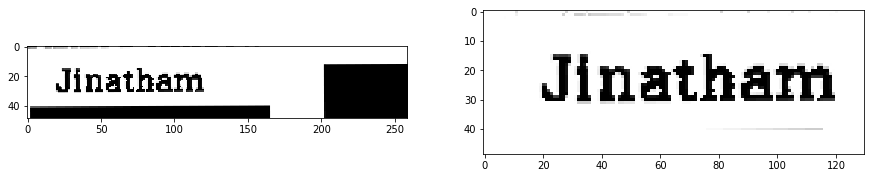

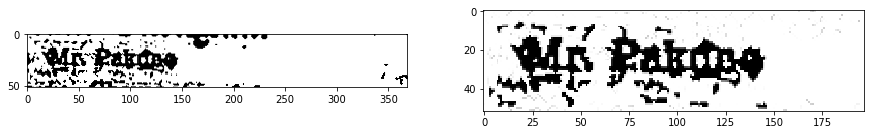

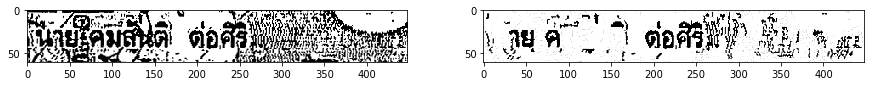

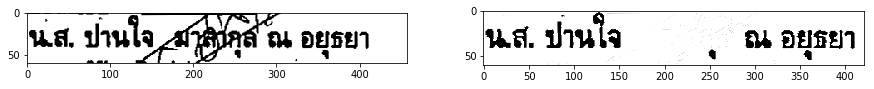

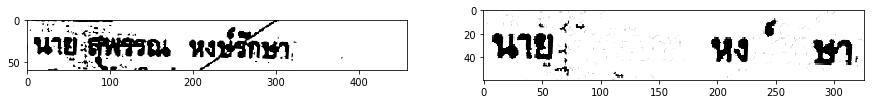

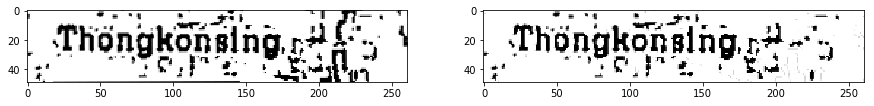

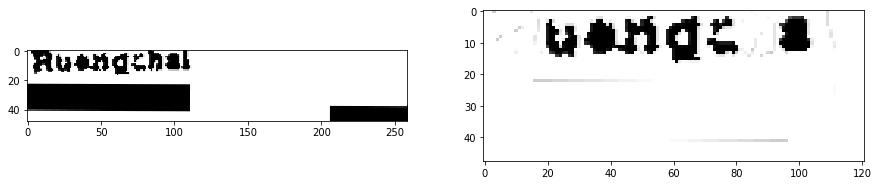

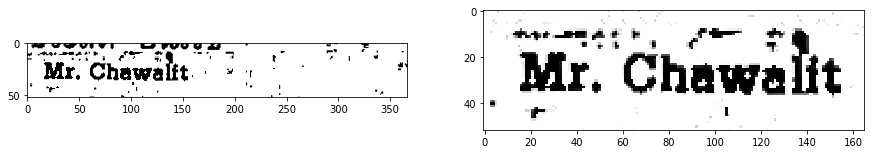

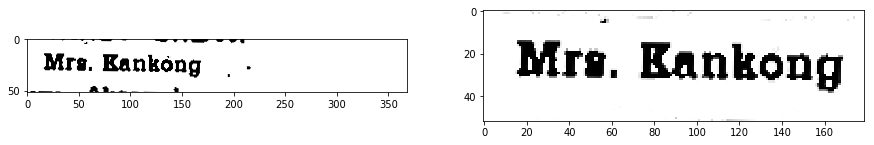

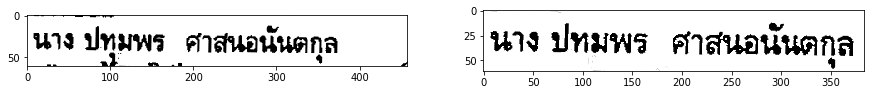

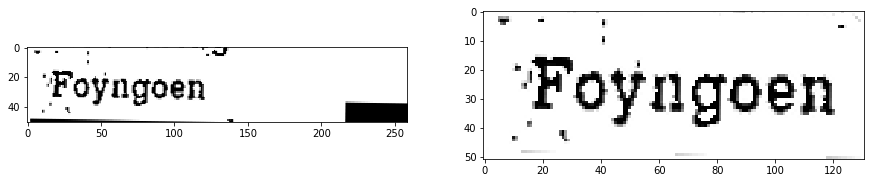

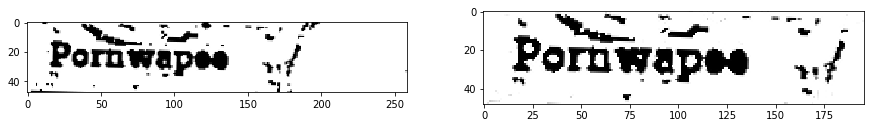

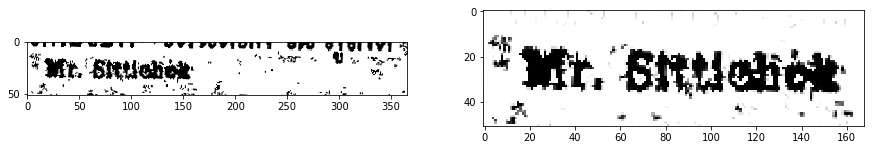

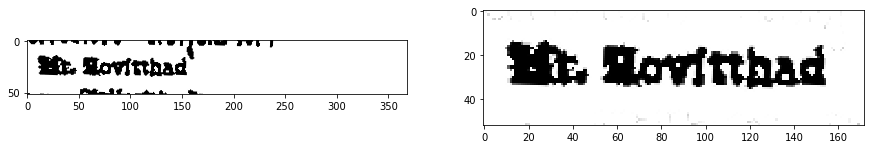

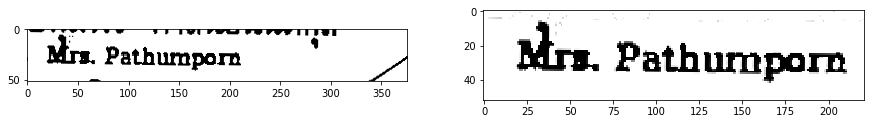

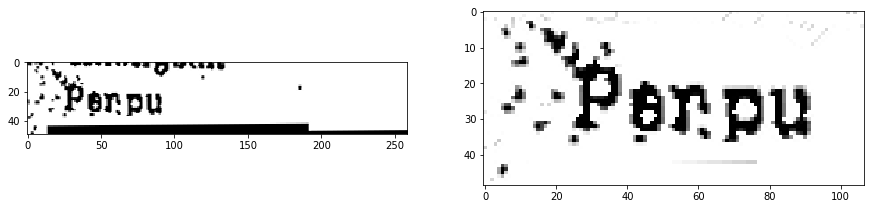

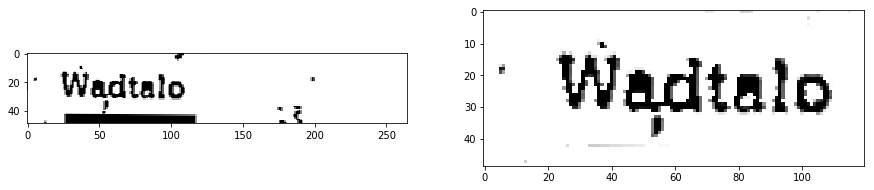

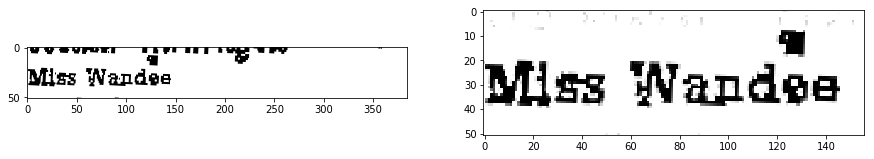

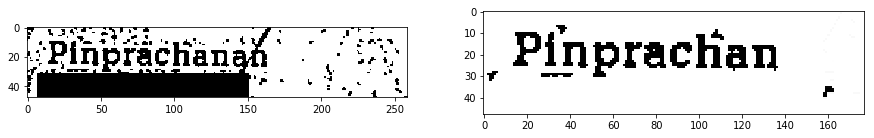

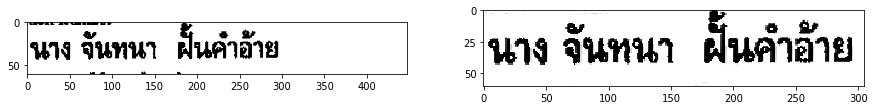

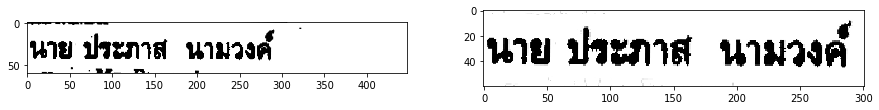

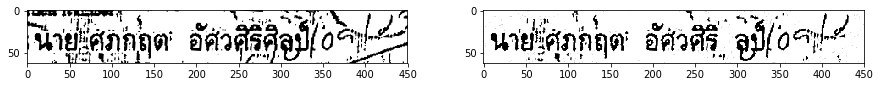

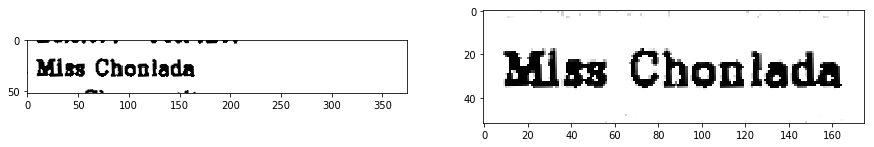

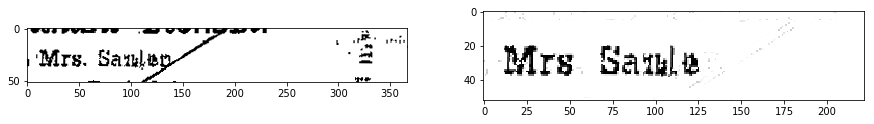

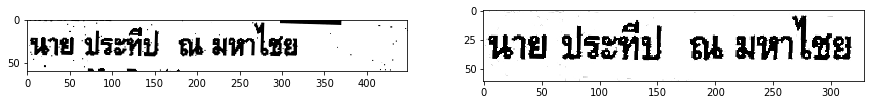

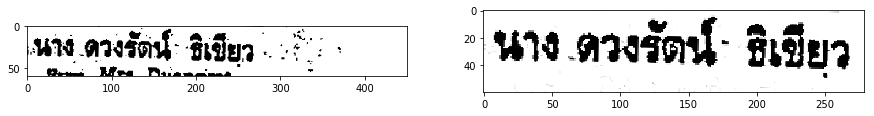

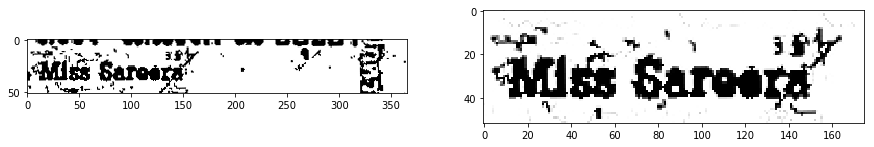

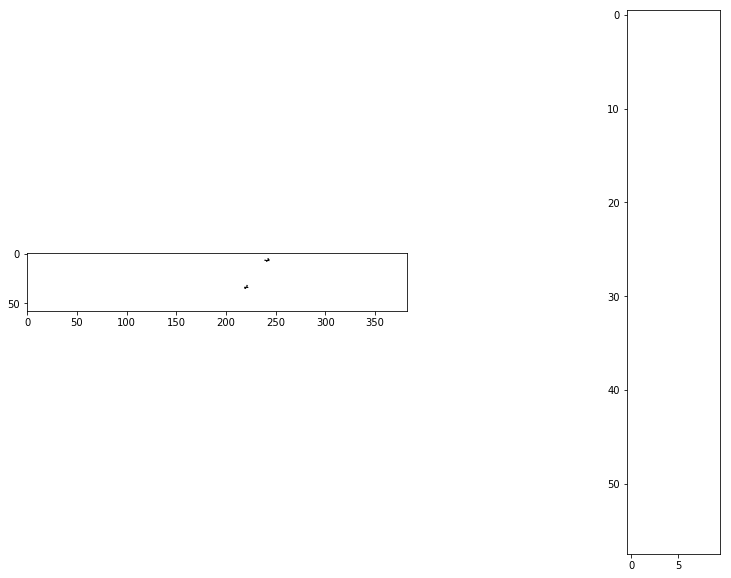

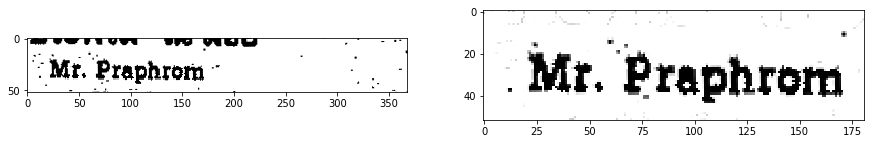

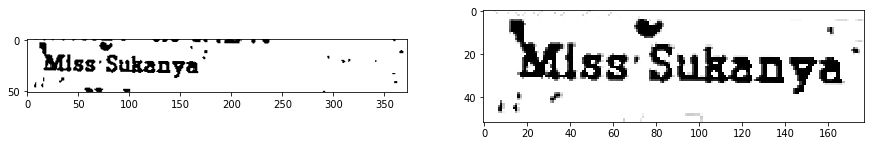

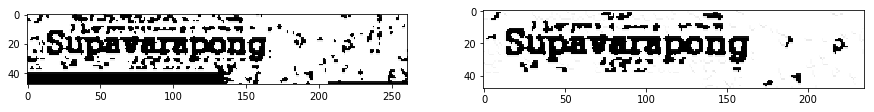

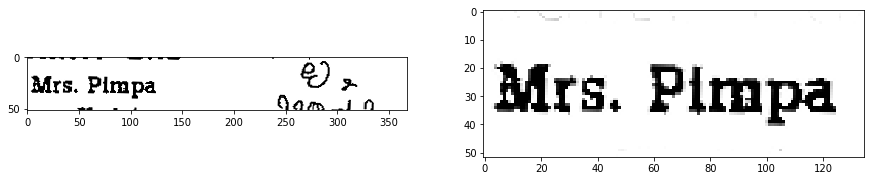

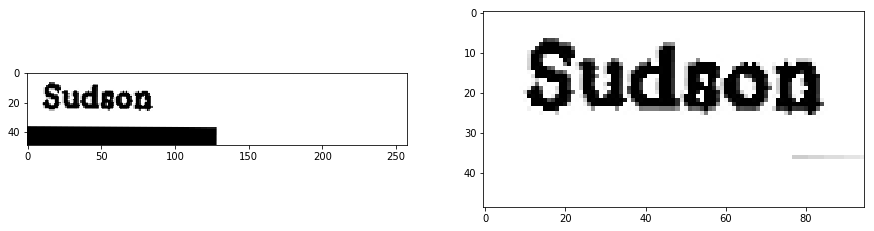

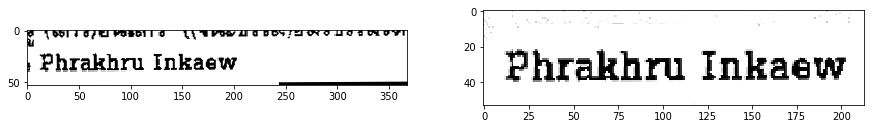

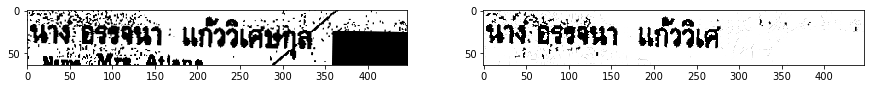

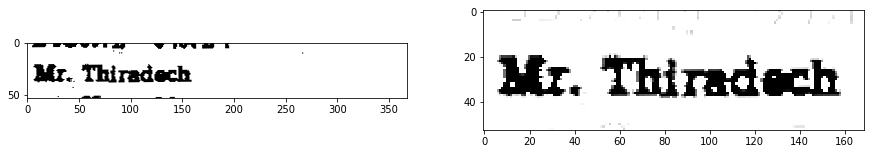

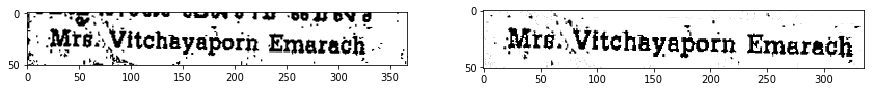

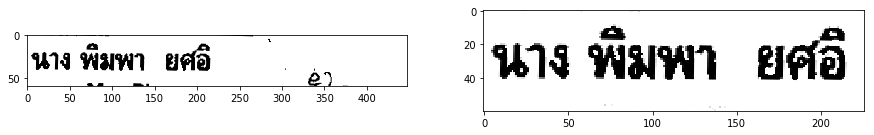

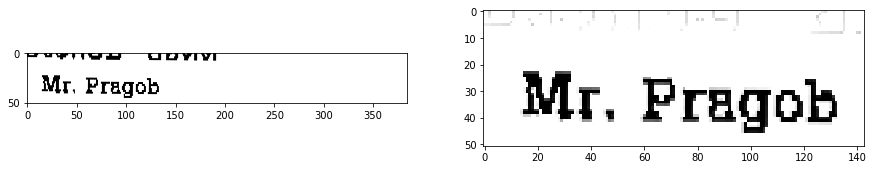

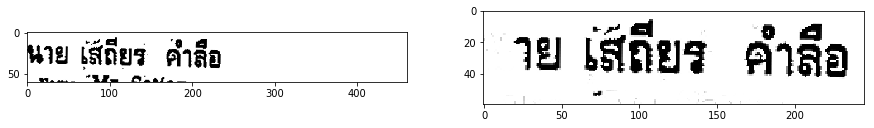

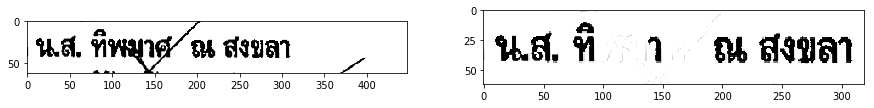

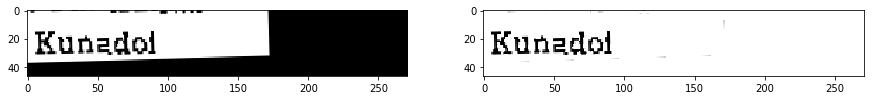

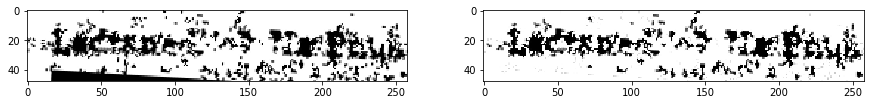

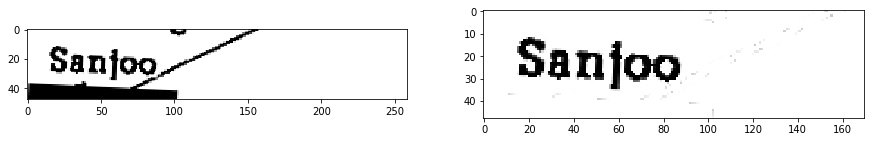

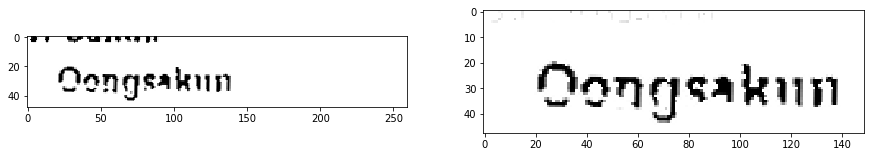

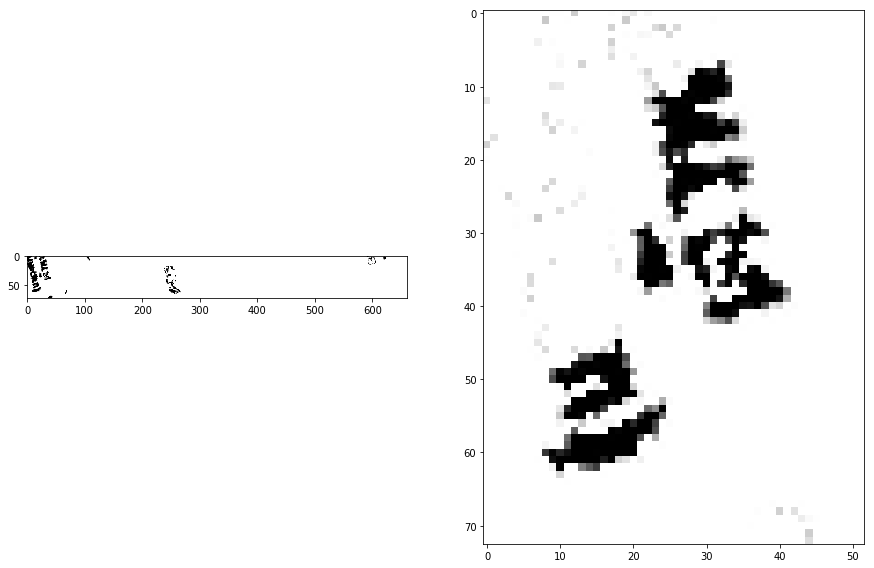

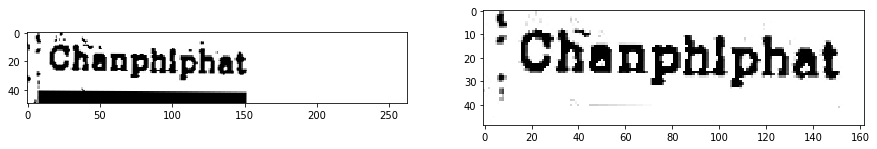

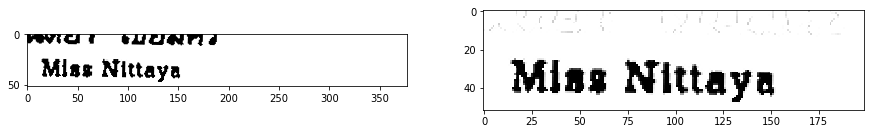

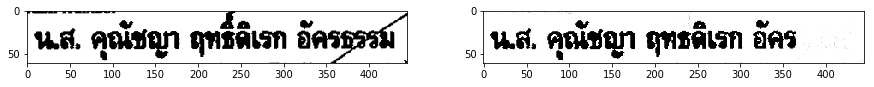

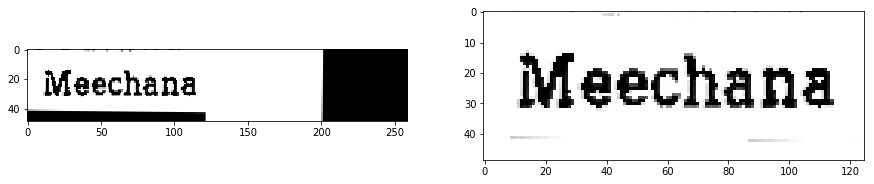

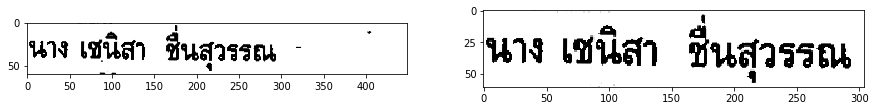

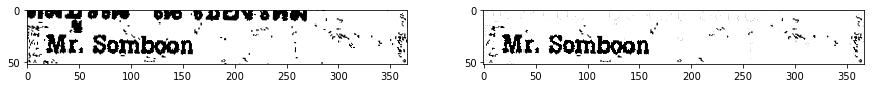

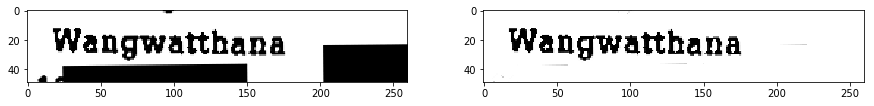

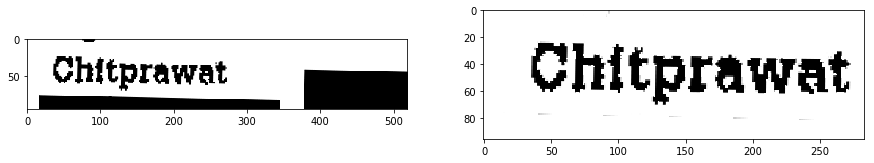

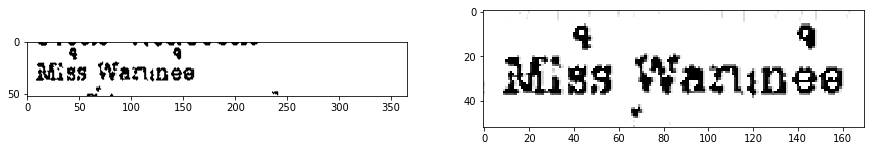

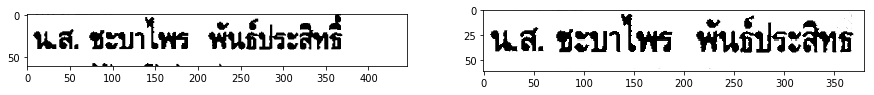

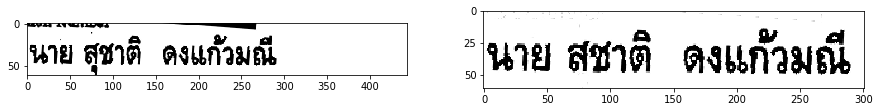

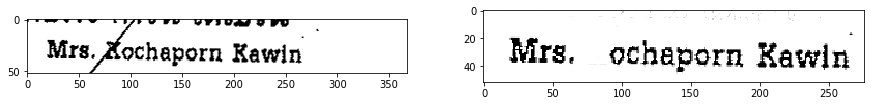

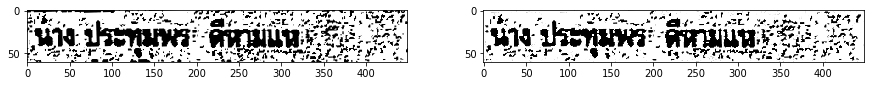

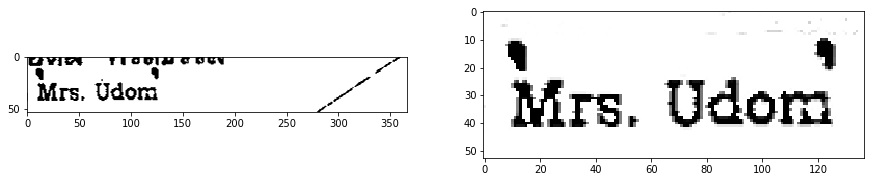

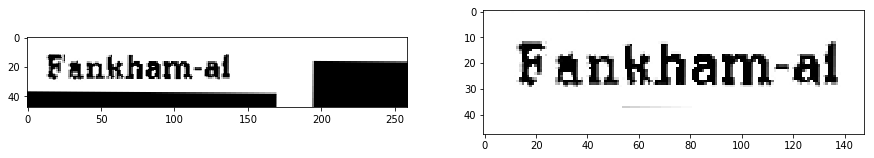

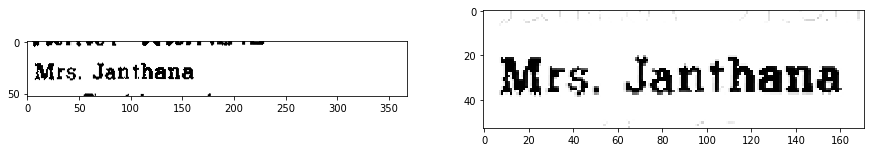

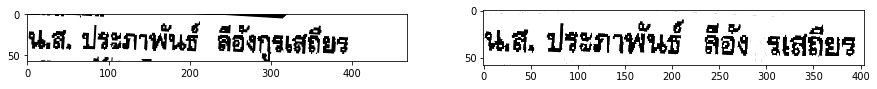

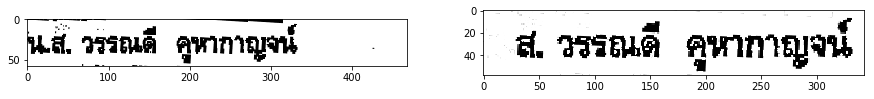

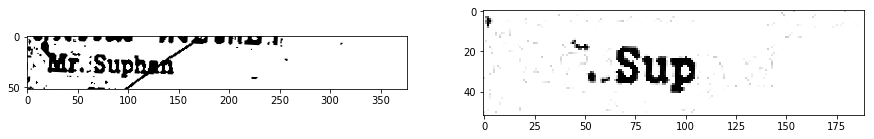

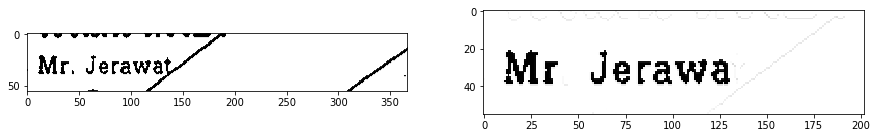

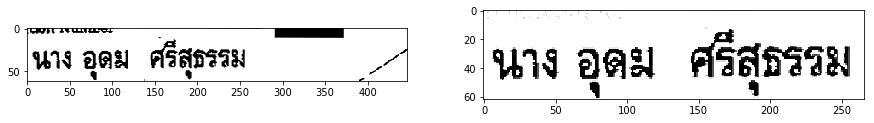

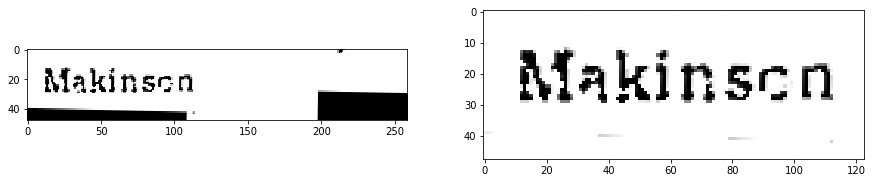

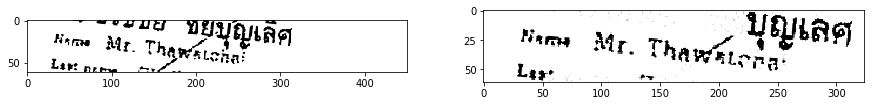

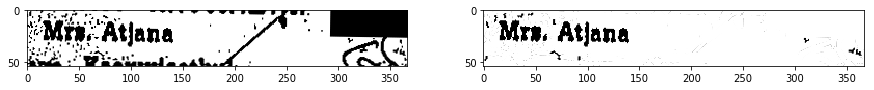

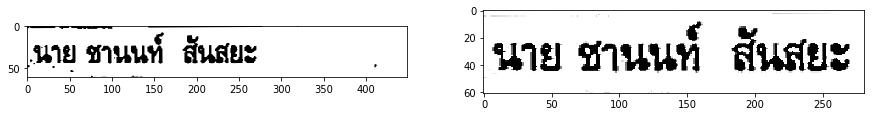

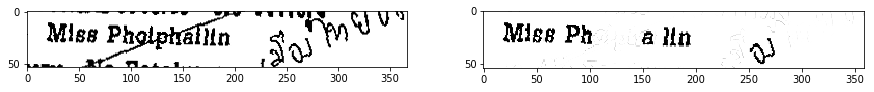

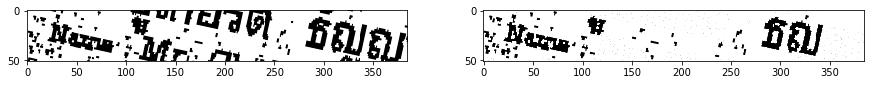

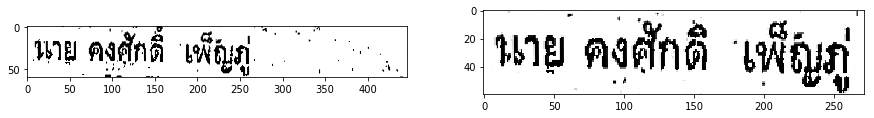

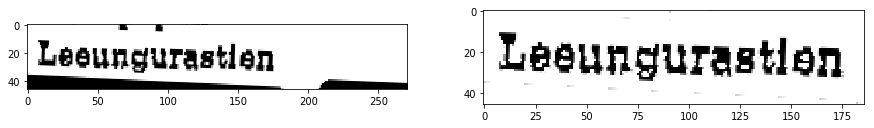

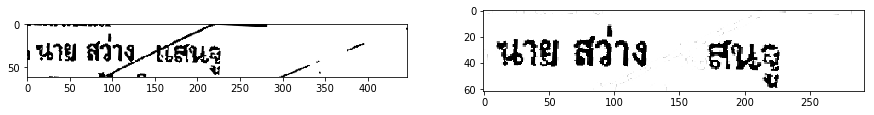

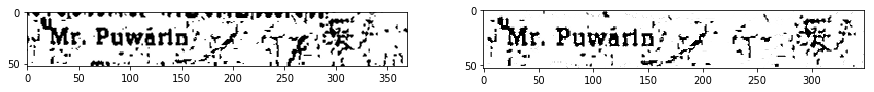

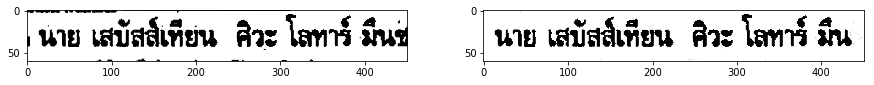

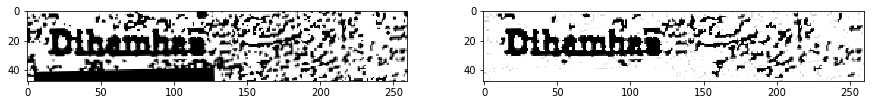

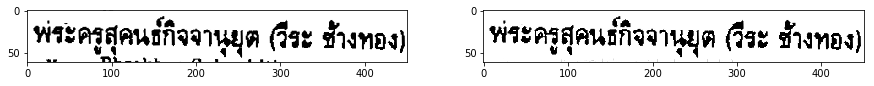

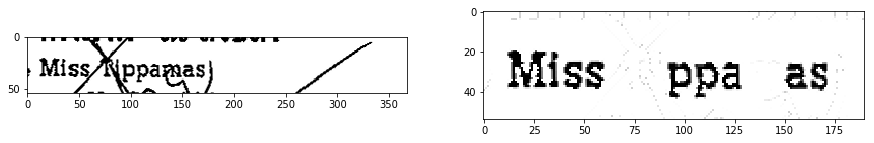

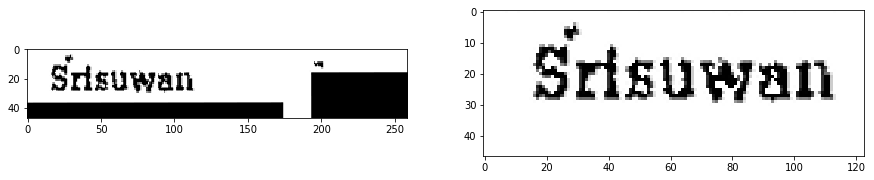

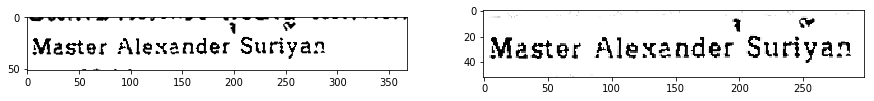

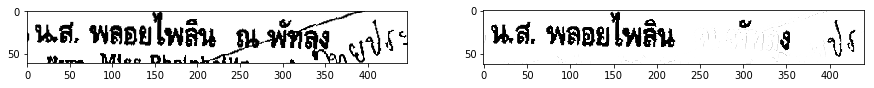

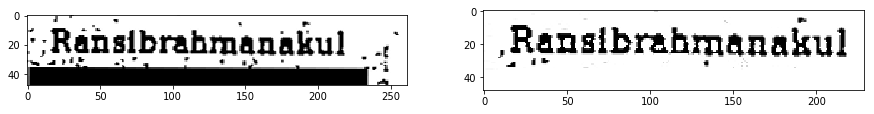

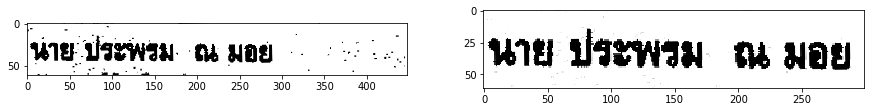

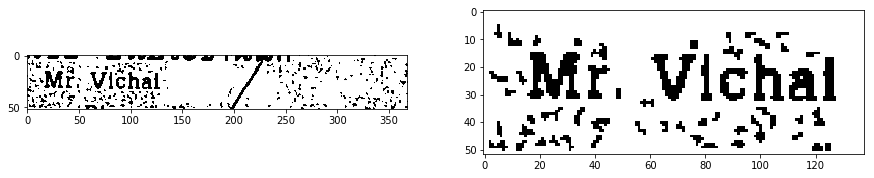

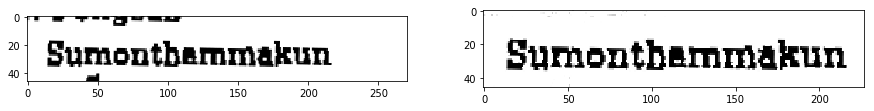

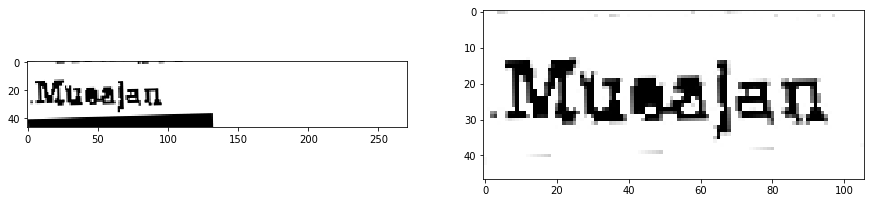

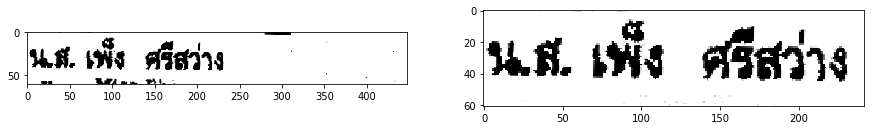

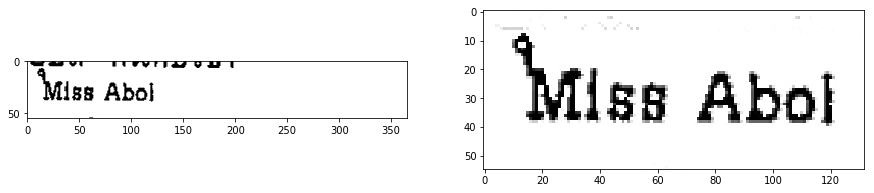

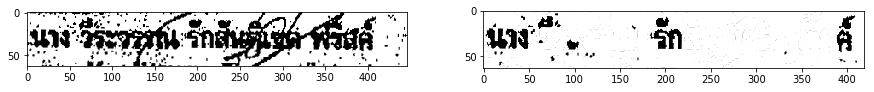

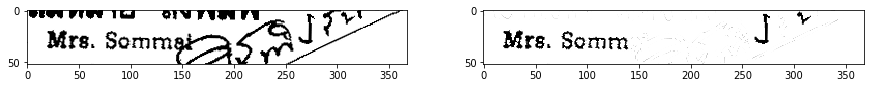

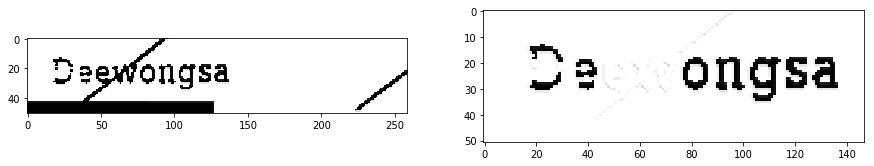

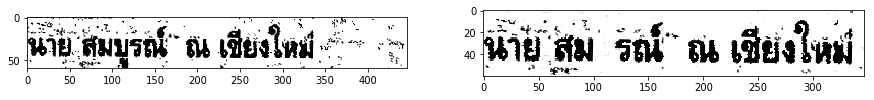

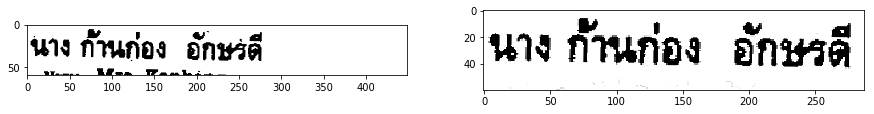

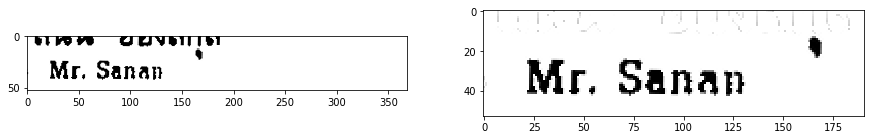

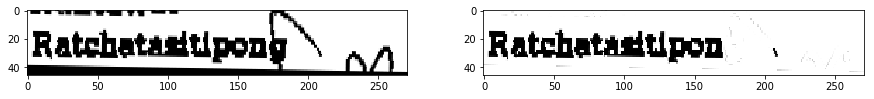

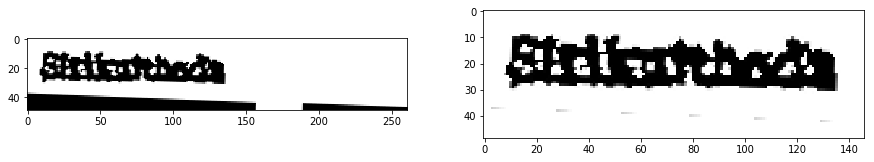

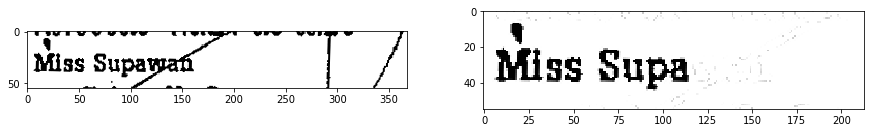

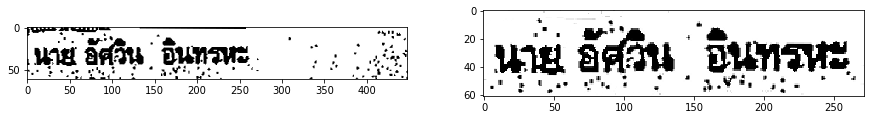

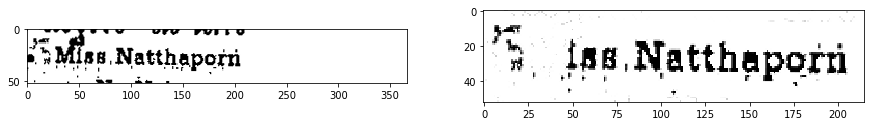

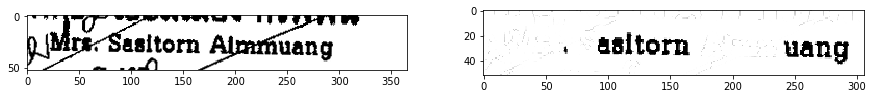

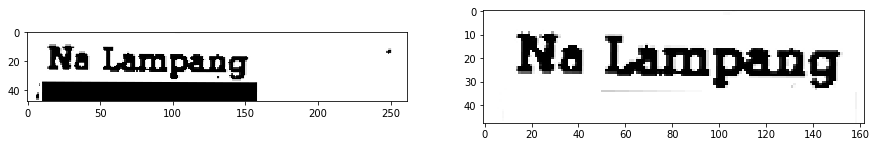

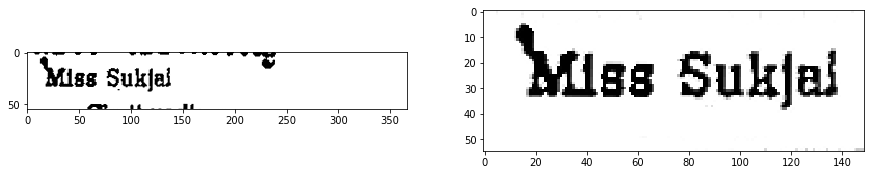

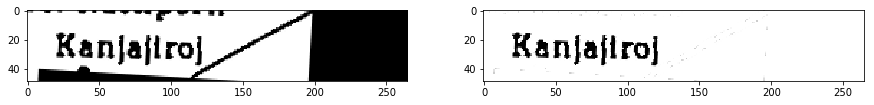

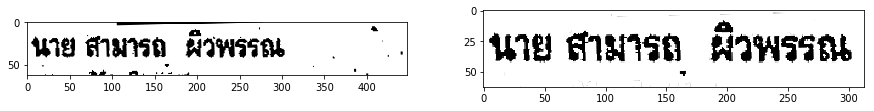

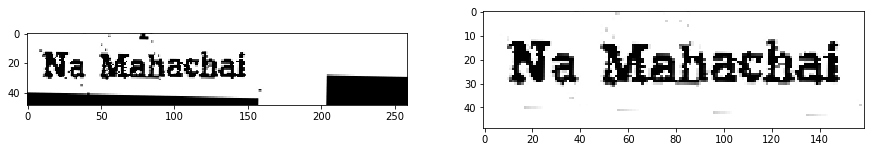

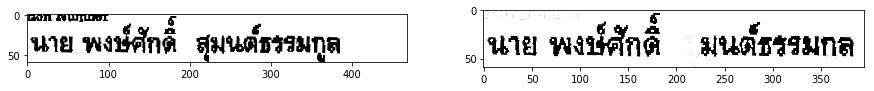

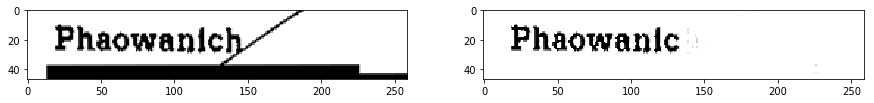

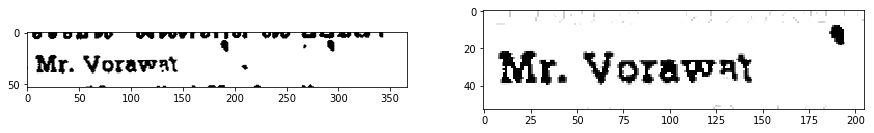

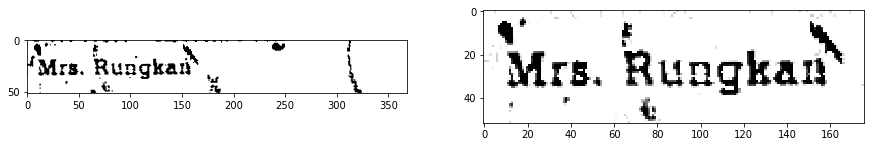

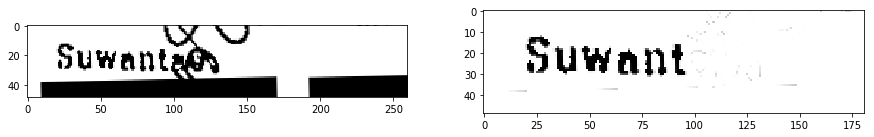

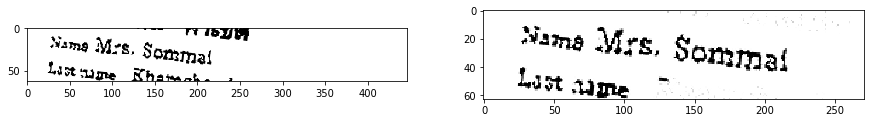

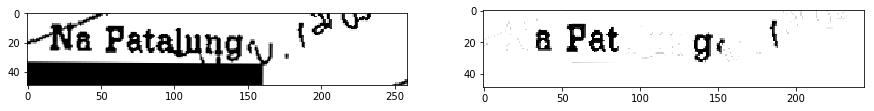

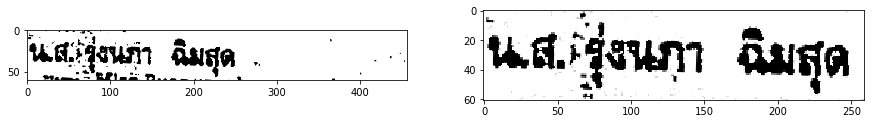

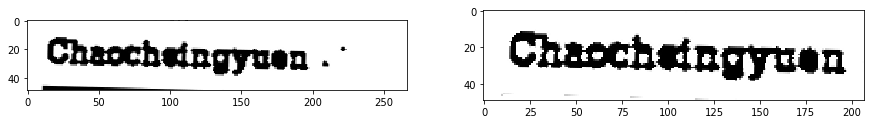

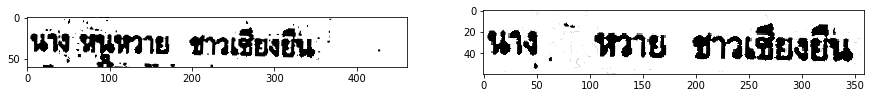

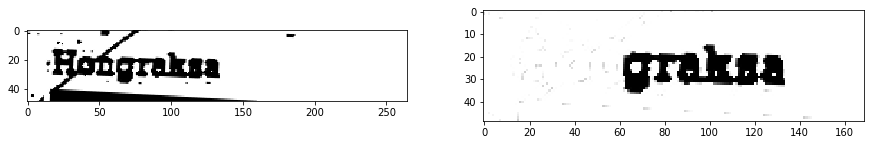

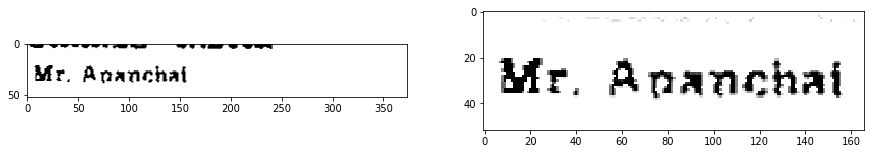

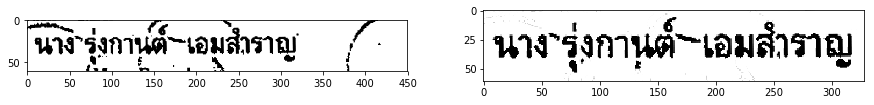

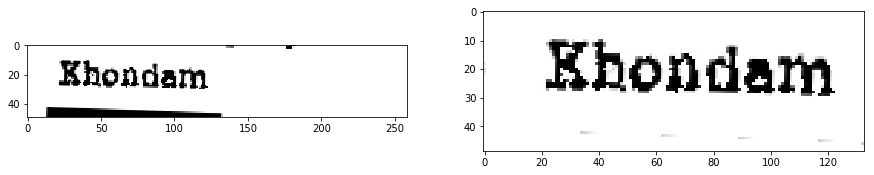

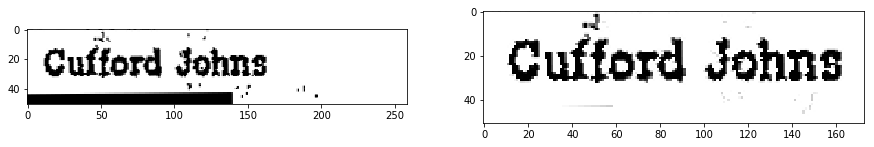

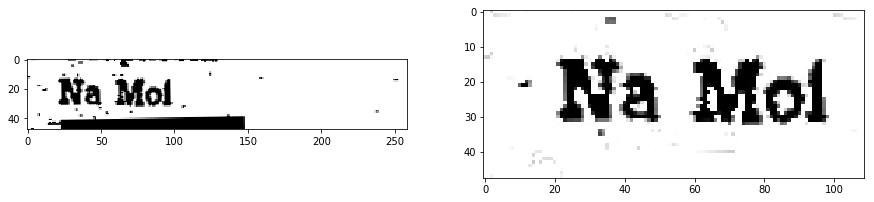

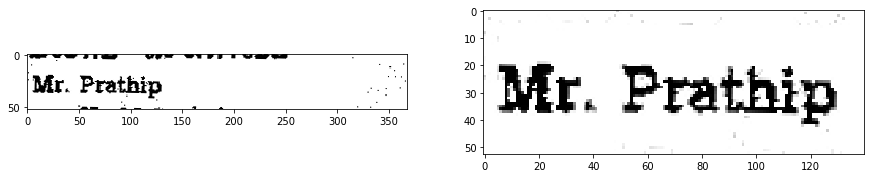

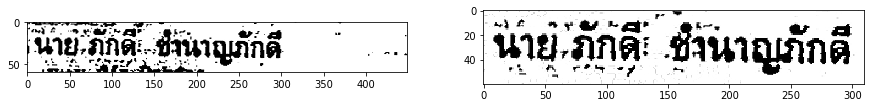

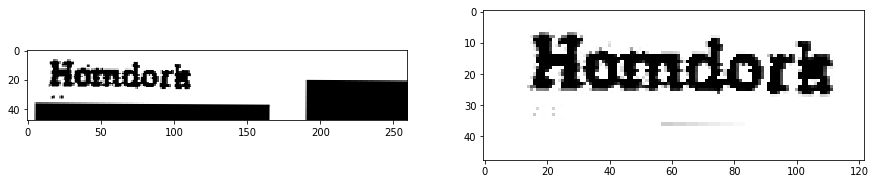

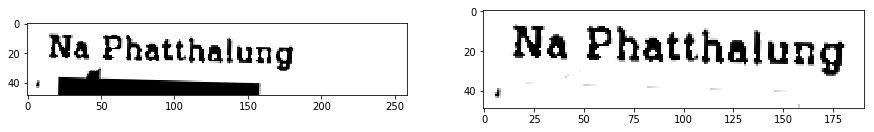

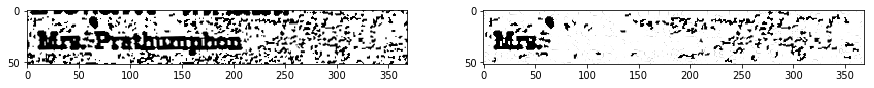

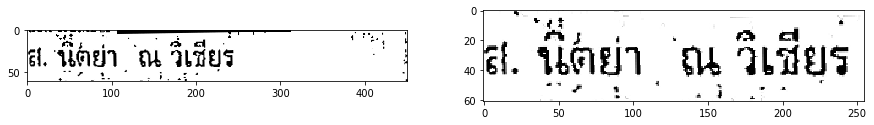

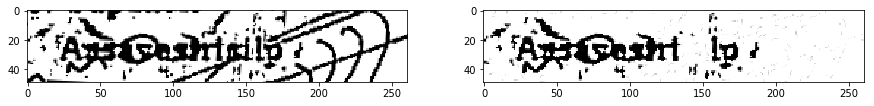

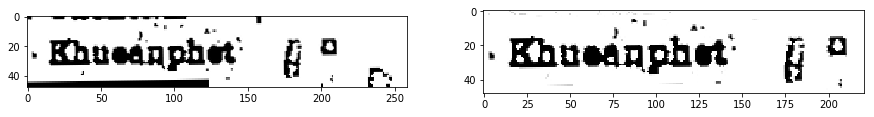

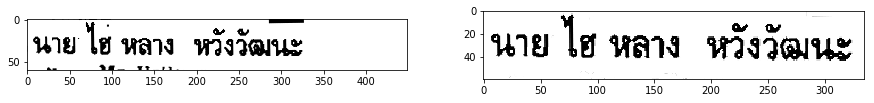

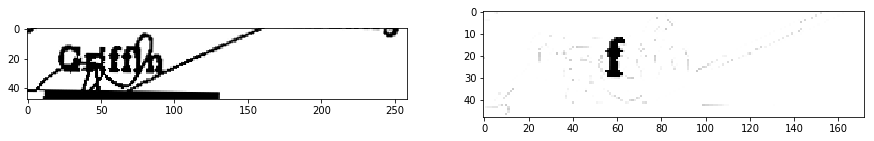

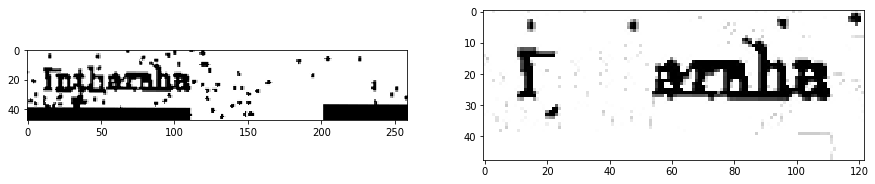

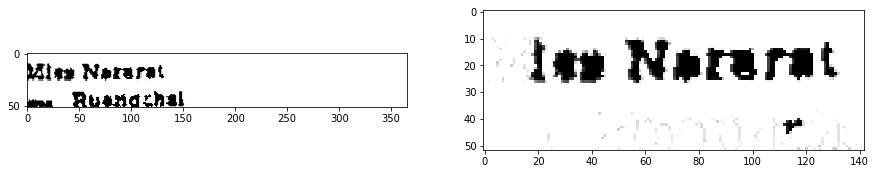

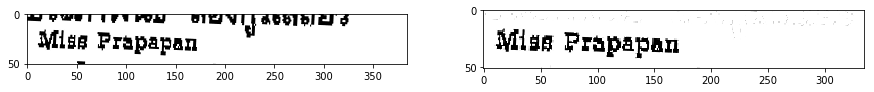

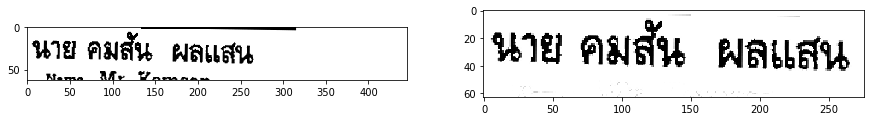

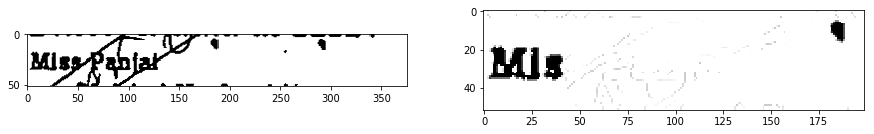

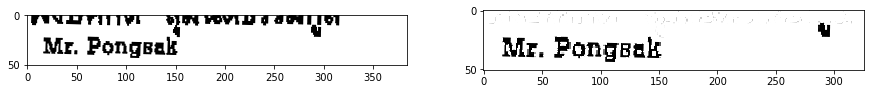

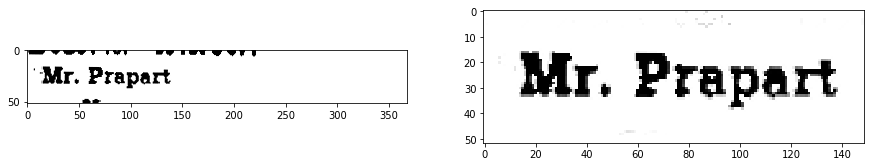

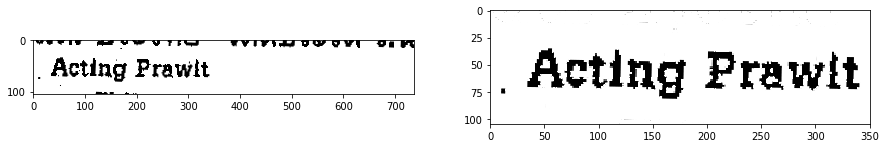

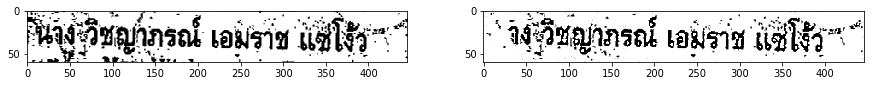

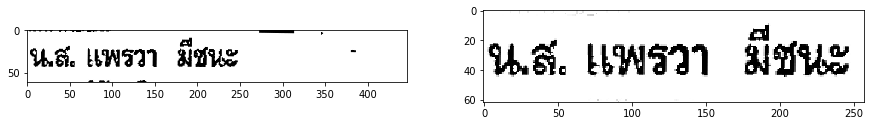

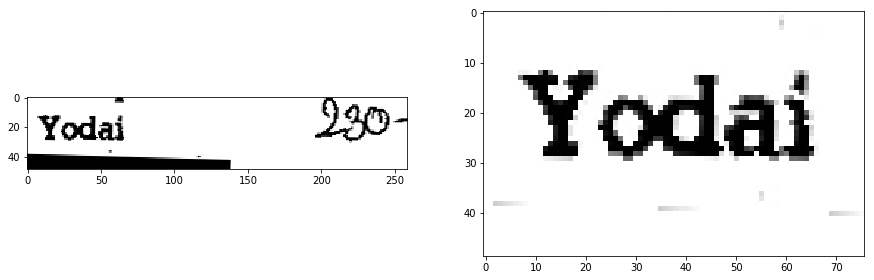

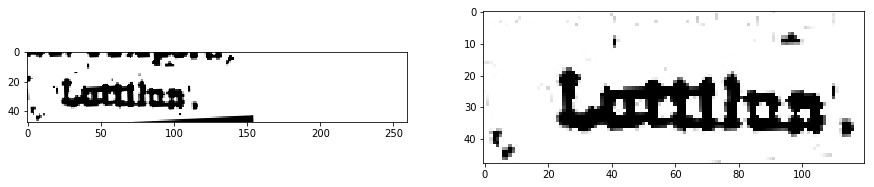

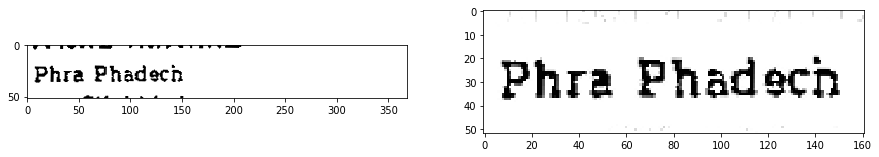

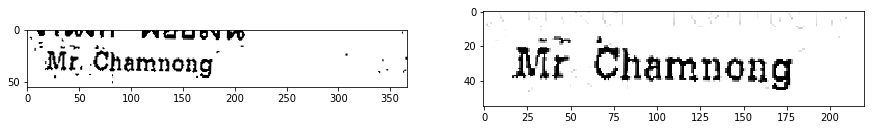

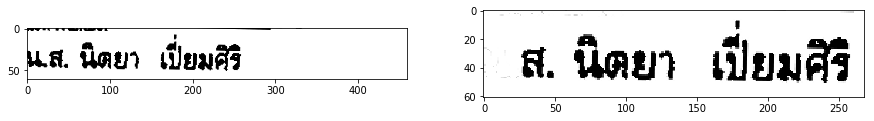

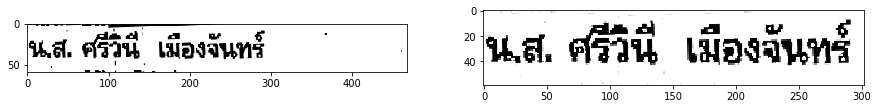

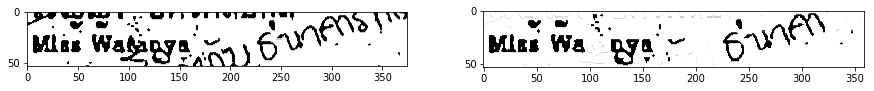

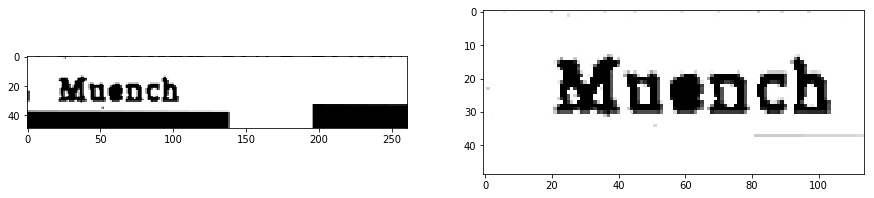

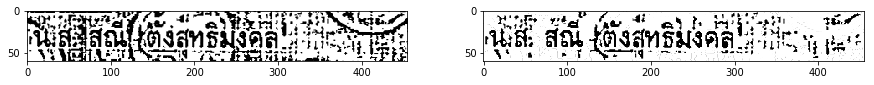

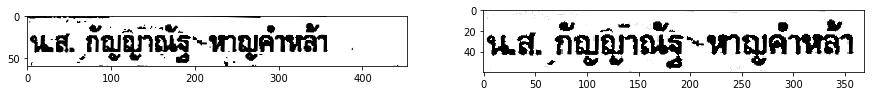

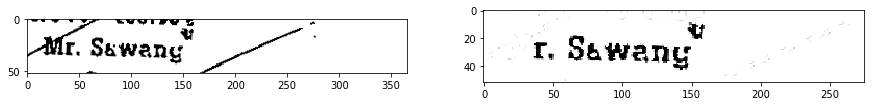

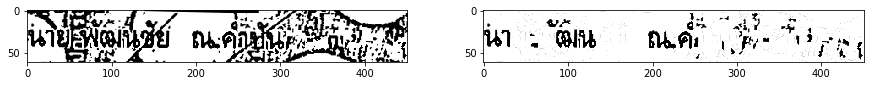

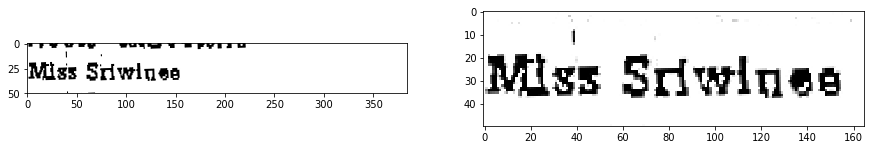

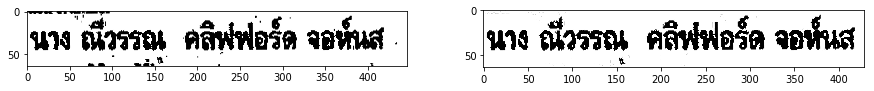

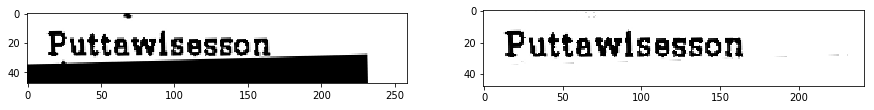

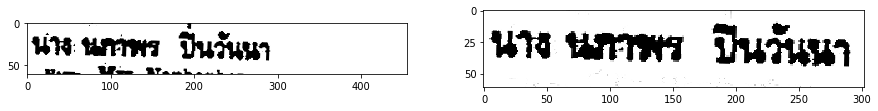

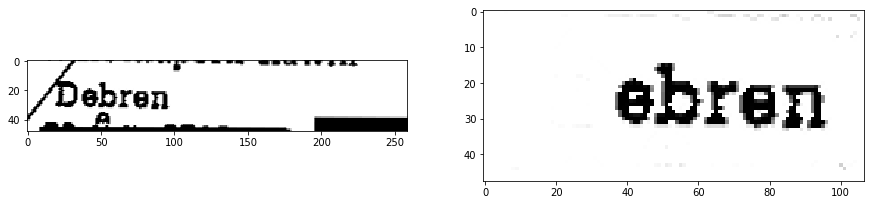

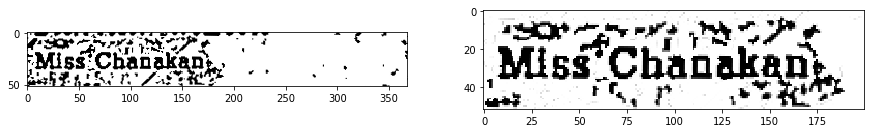

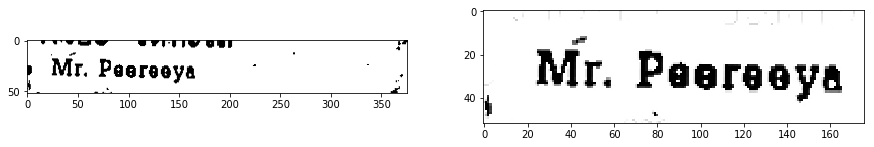

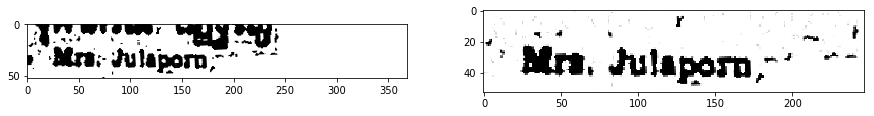

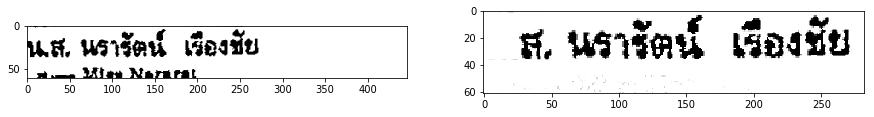

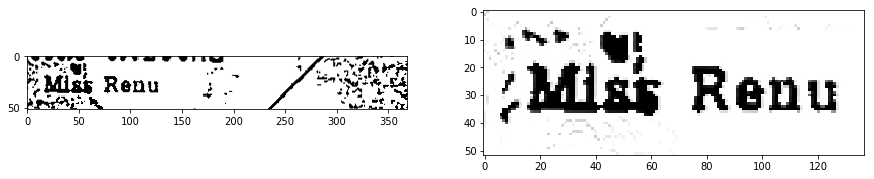

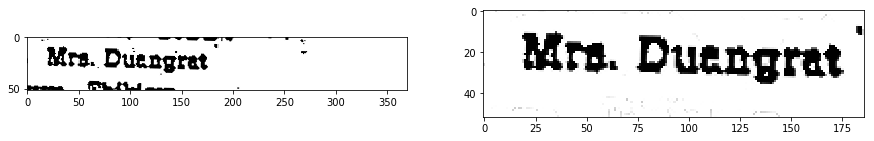

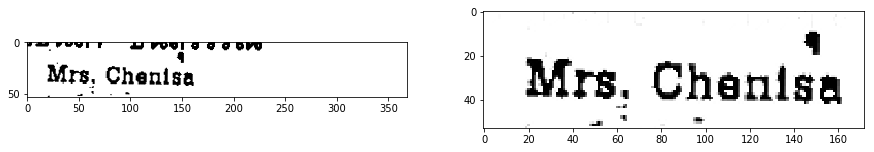

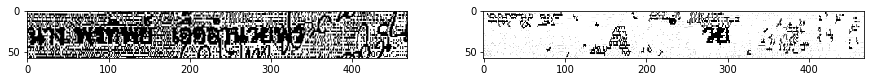

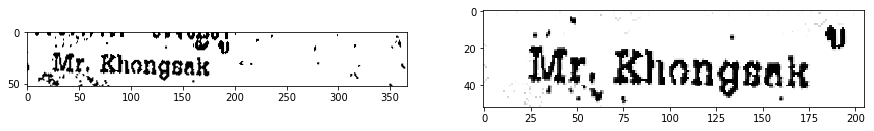

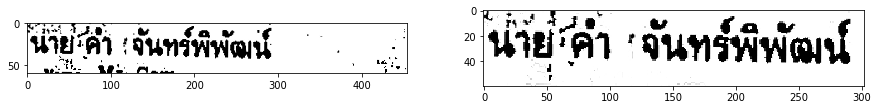

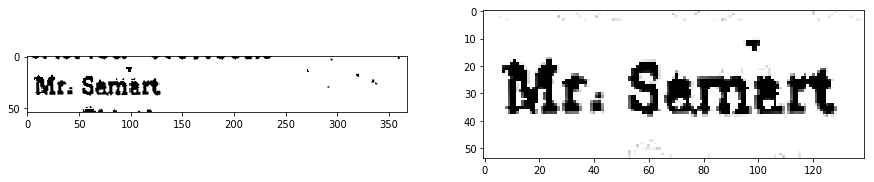

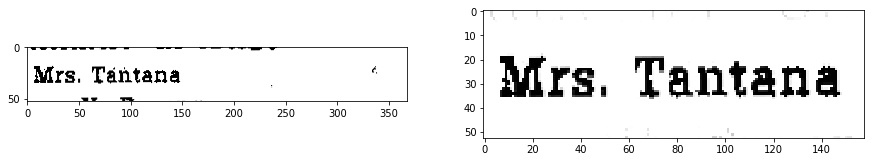

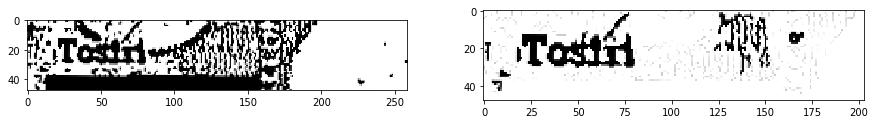

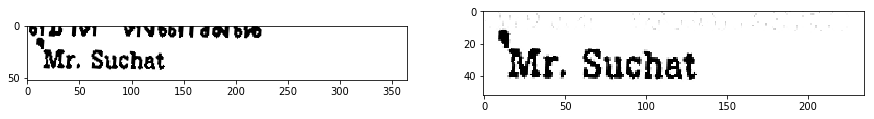

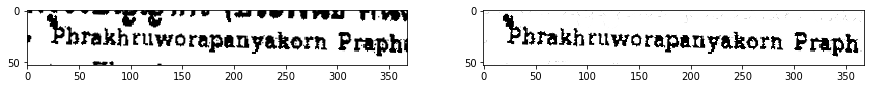

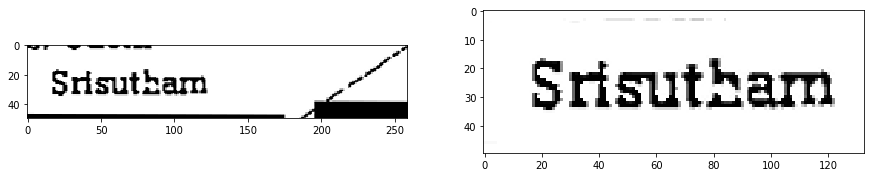

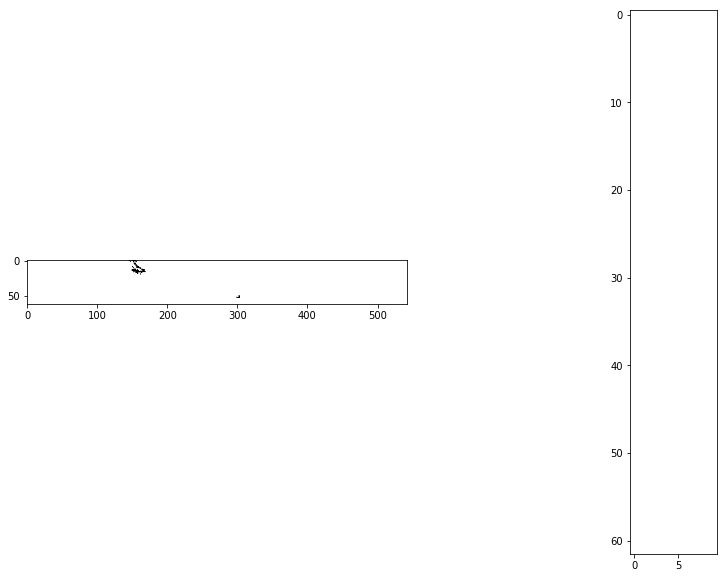

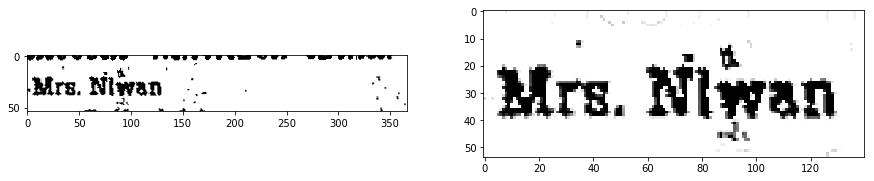

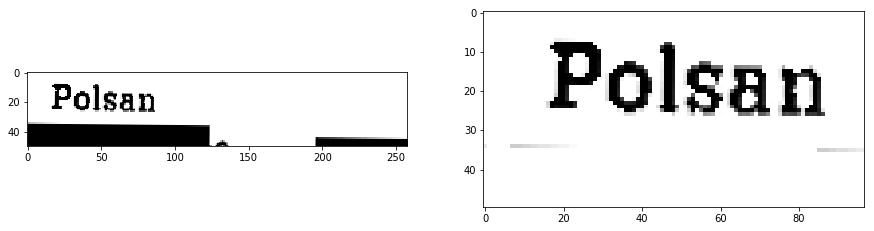

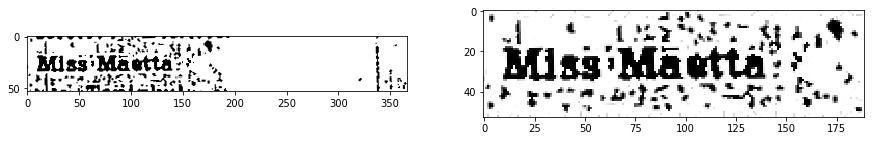

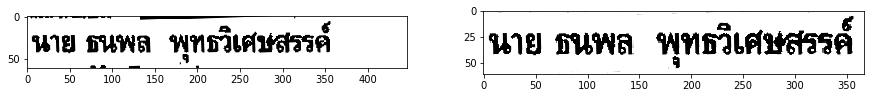

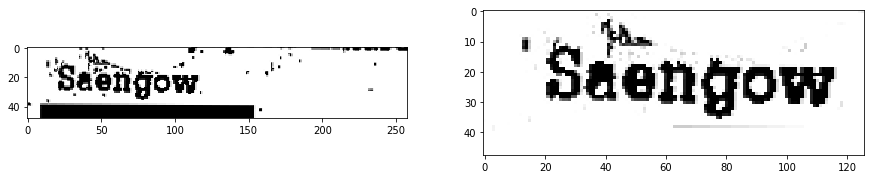

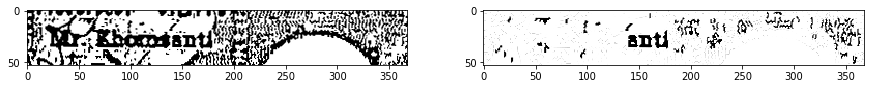

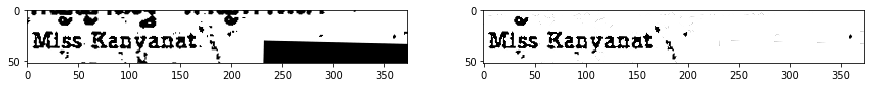

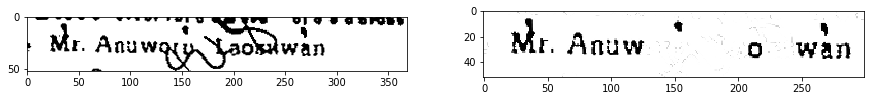

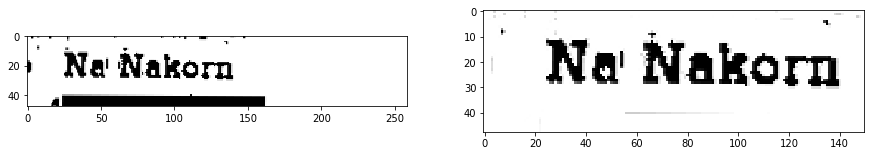

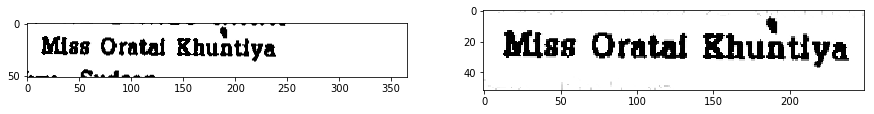

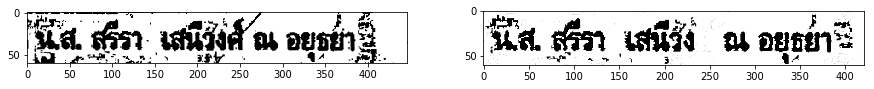

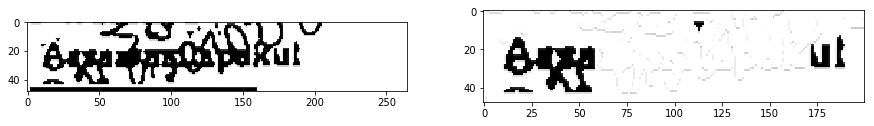

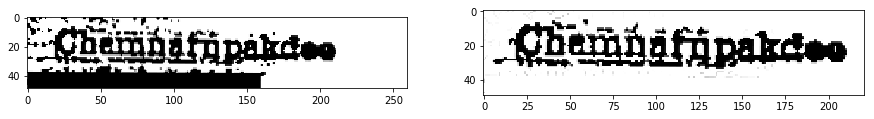

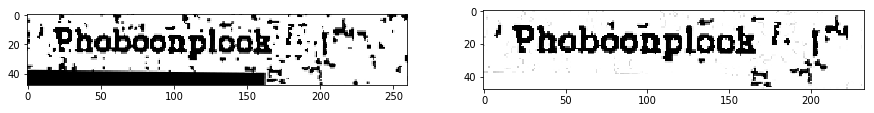

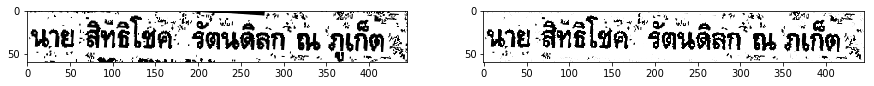

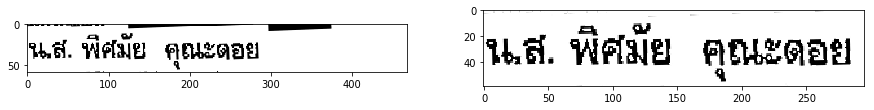

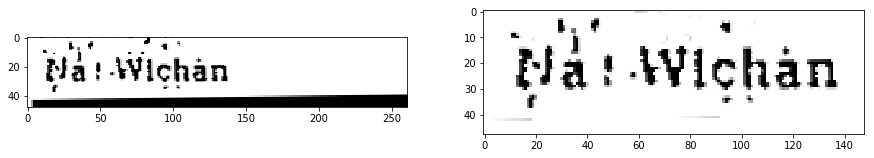

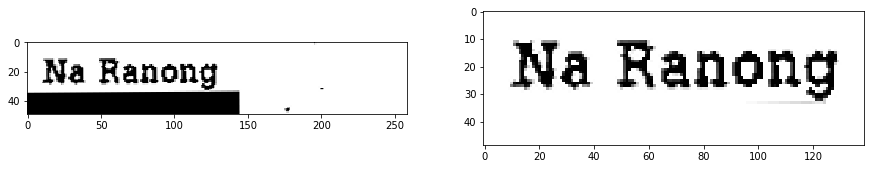

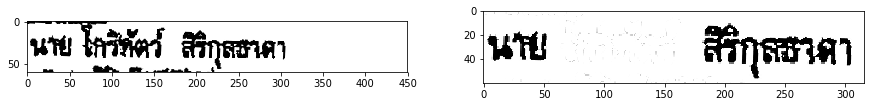

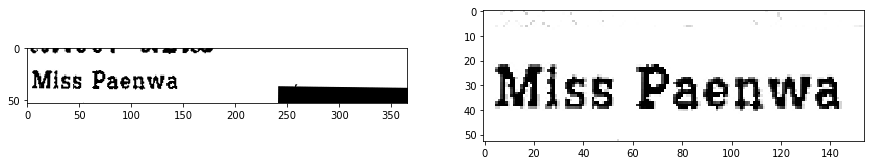

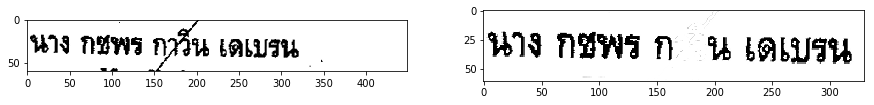

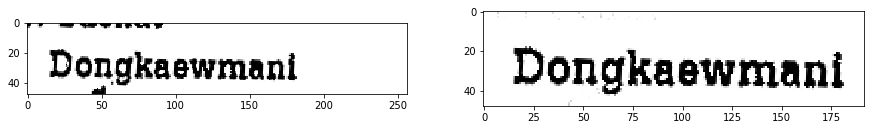

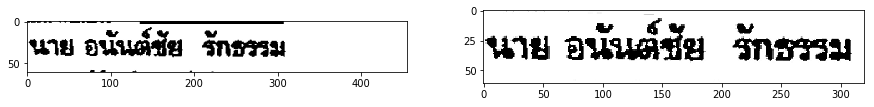

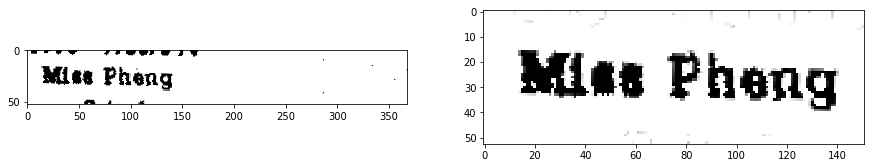

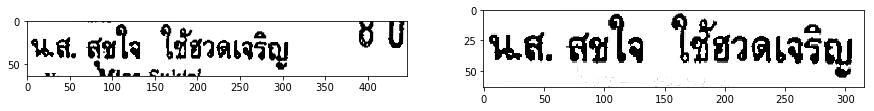

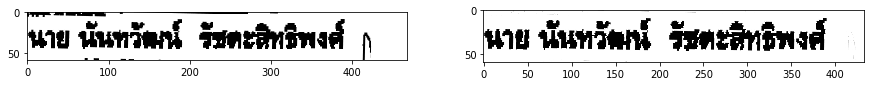

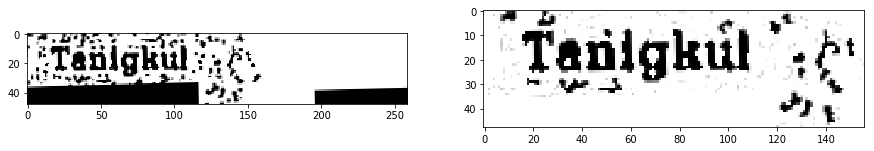

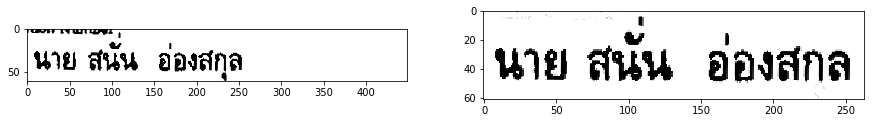

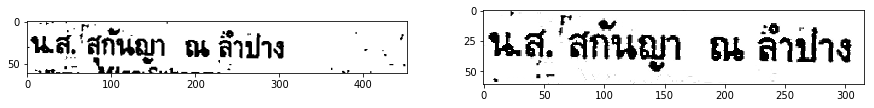

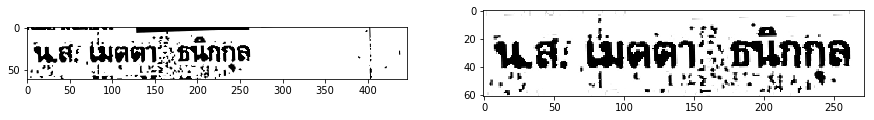

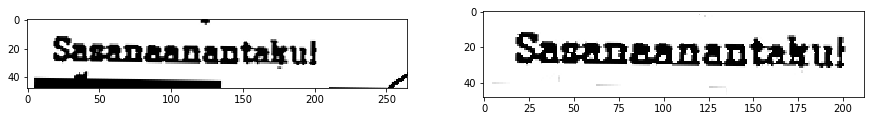

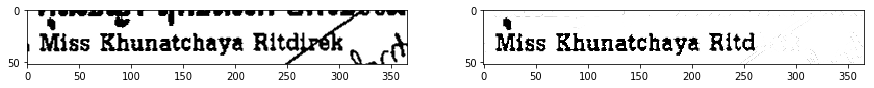

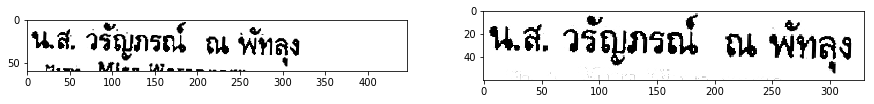

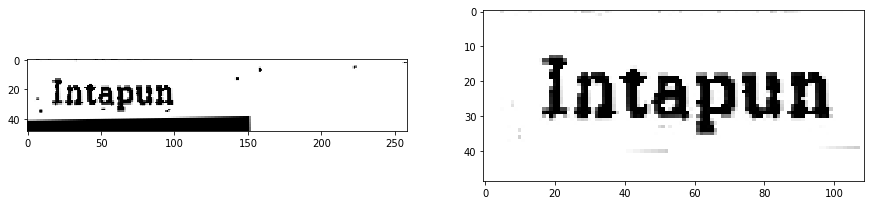

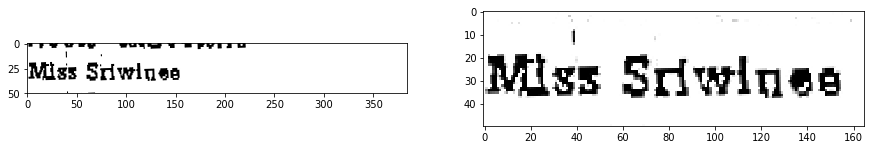

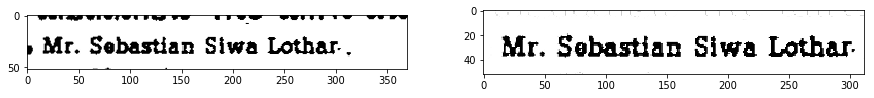

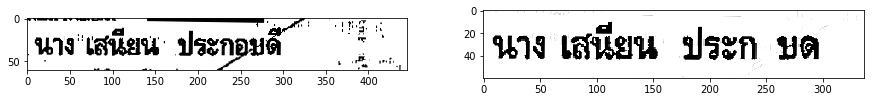

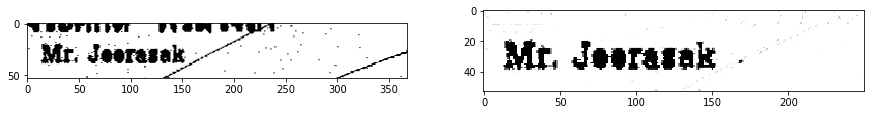

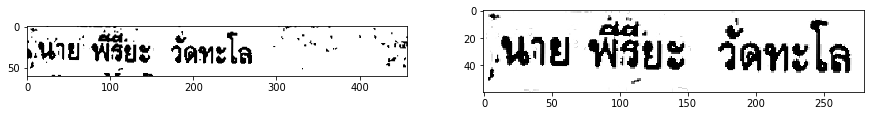

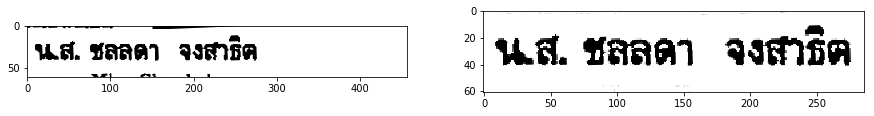

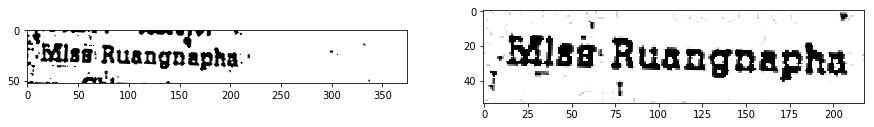

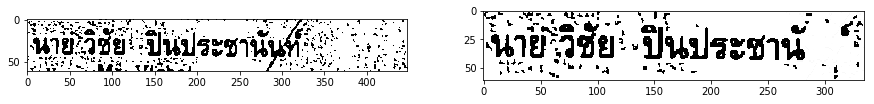

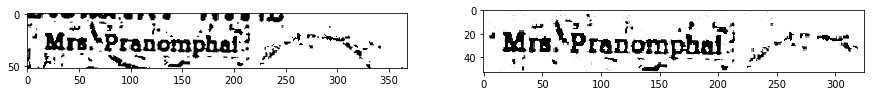

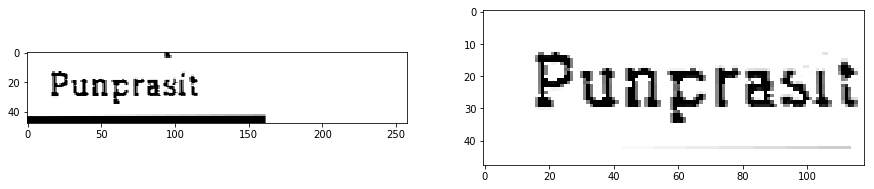

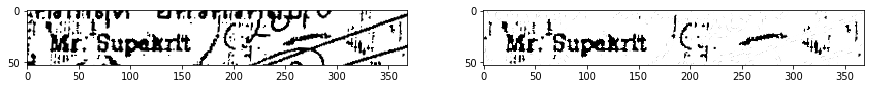

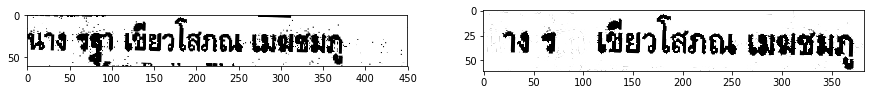

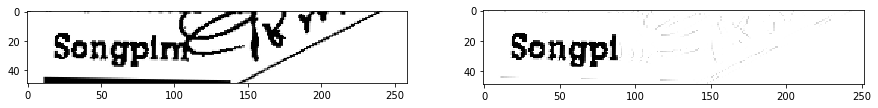

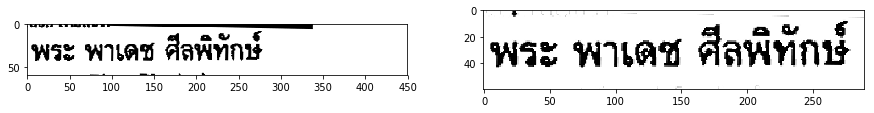

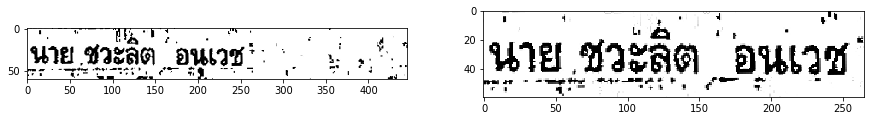

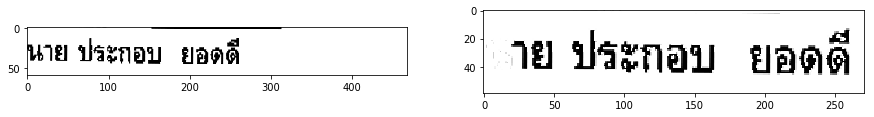

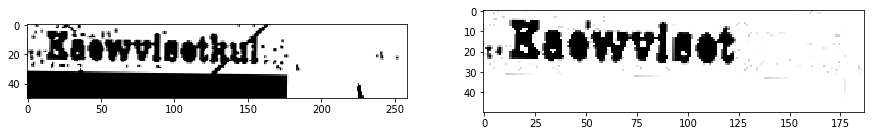

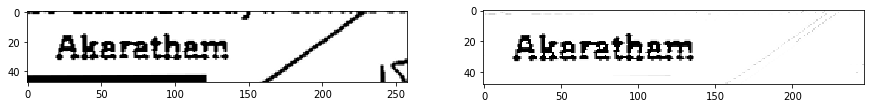

In [322]:
for file in glob.glob("text_boxes/cropped_bigger/name/*"):
    denoiseBoxFromPath(file, "/home/paeby/Documents/Dathena/cv_mtl_die/text_boxes/denoised/cropped_name")
    